# Following by Cao, 2016

## Цель работы:

    1. Реализовать алгоритмы спектральной и колориметрической реконструкции на основе применения взвешенных версий PCA, описанных в Cao et al.(2016).

    2. Сравнить результаты реконструкций спектров на основании среднего RMSE. В случае колориметрической репродукции - на основании двух метрик цветового различия CIE L*a*b* 1976 и CIEDE 2000.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

### Чтение и обзор данных

В качестве обучающих данных в работе используются 1600 спектров поверхностного отражения Munsell colors glossy, в качестве тестовых данных - небольшой набор из датасета NCS, включающий в себя 183 спектра природных объектов (листья, цветы и проч.). Также, в последней части используются даные 337 спектров окрасок листьев берёз, 370 спектров хвои сосен и 349 спектров, соответсвюущих окраскам хвои елей.

Два основных осветителя, используемые для колориметрической реконструкции, - стандартные осветители CIE D65 и A (соответственно - нормальное дневное освещение и нормальное комнатное освещение вольфрамовой нитью).

В качестве функций чувствительности используются функции цветового захвата для стандаратного наблюдателя CIE 1931.

Все спектральные данные лежат в диапазоне длин волн от 400 нм до 700 нм с интервалом в 5 нм. Заметим, что в оригинальной работе Cao использовался несколько иной набор спектральных данных, и дискретизация составляла 10 нм.

In [2]:
with open('natural400_700_5.json', 'r') as read_file:
    natural = json.load(read_file)
    
with open('munsell380_780_1_glossy.json', 'r') as read_file:
    munsell = json.load(read_file)

In [3]:
grid = natural['lambdas']

In [4]:
natural_reflect = np.array([grid])
for key in natural['data'].keys():
    natural_reflect = np.concatenate(( natural_reflect, np.array([natural['data'][key]]) ), axis=0)
natural_reflect = np.delete(natural_reflect, 0, 0)
natural_reflect =  pd.DataFrame(natural_reflect, columns=grid)

In [5]:
max(natural_reflect.max(axis=0).values)

4096.0

In [6]:
natural_reflect /= max(natural_reflect.max(axis=0).values)
natural_reflect.head()

,400,405,410,415,420,425,430,435,440,445,...,655,660,665,670,675,680,685,690,695,700
0,0.128174,0.066650,0.000000,0.092285,0.077637,0.040039,0.054688,0.067383,0.077148,0.064941,...,0.090820,0.089111,0.096436,0.091553,0.093262,0.111816,0.135498,0.174805,0.244629,0.343506
1,0.000000,0.160645,0.010986,0.000000,0.000000,0.031982,0.023926,0.020508,0.030029,0.025391,...,0.492920,0.484131,0.481201,0.478760,0.492188,0.477539,0.475098,0.469238,0.484131,0.486084
2,0.352783,0.174561,0.195557,0.164062,0.108154,0.099121,0.129639,0.126465,0.123047,0.119141,...,0.120361,0.119873,0.126465,0.127197,0.129150,0.131836,0.139160,0.161621,0.198242,0.261719
3,0.153809,0.107178,0.142822,0.000000,0.030029,0.063721,0.023926,0.037598,0.052734,0.050049,...,0.599854,0.596924,0.585449,0.572754,0.583252,0.586426,0.577637,0.581055,0.606445,0.614014
4,0.230713,0.339111,0.373535,0.276367,0.259033,0.242920,0.211426,0.221680,0.229736,0.230469,...,0.335449,0.334961,0.338379,0.350342,0.364502,0.346924,0.357422,0.352539,0.355957,0.360352


In [7]:
delete_column_munsell = []
for i in munsell['lambdas']:
    if i not in grid:
        delete_column_munsell.append(i)

In [8]:
munsell_reflect = np.array([munsell['lambdas']])
for key in munsell['data'].keys():
    munsell_reflect = np.concatenate(( munsell_reflect, np.array([munsell['data'][key]]) ), axis=0)   
munsell_reflect = np.delete(munsell_reflect, 0, 0)
munsell_reflect =  pd.DataFrame(munsell_reflect, columns=munsell['lambdas'])
munsell_reflect = munsell_reflect.drop(columns=delete_column_munsell)
munsell_reflect.head()

,400,405,410,415,420,425,430,435,440,445,...,655,660,665,670,675,680,685,690,695,700
0,0.078697,0.079767,0.080183,0.080370,0.081190,0.081547,0.081918,0.082121,0.082285,0.082753,...,0.064277,0.064627,0.064750,0.064637,0.064718,0.065069,0.064560,0.064675,0.064823,0.065508
1,0.079847,0.081282,0.081785,0.082694,0.084147,0.085678,0.086314,0.087980,0.090027,0.091065,...,0.057187,0.057800,0.057826,0.057528,0.057891,0.057922,0.057804,0.057739,0.058313,0.058261
2,0.074807,0.077182,0.078314,0.079565,0.080832,0.082984,0.084430,0.087439,0.091467,0.094859,...,0.054575,0.054994,0.055019,0.055283,0.054524,0.054443,0.055083,0.054833,0.055482,0.055908
3,0.111945,0.114882,0.115602,0.117023,0.117483,0.118369,0.118794,0.119080,0.119556,0.119884,...,0.082283,0.082771,0.082809,0.083439,0.083796,0.083969,0.083609,0.084265,0.083978,0.084991
4,0.114155,0.116397,0.118895,0.120867,0.121606,0.123578,0.125344,0.127553,0.129009,0.132893,...,0.077711,0.078189,0.077850,0.077640,0.077343,0.076822,0.075539,0.075454,0.076052,0.076426


In [9]:
munsell_reflect.shape, natural_reflect.shape

((1600, 61), (183, 61))

In [10]:
def read_data(name_set):
    data = []

    with open(name_set, 'r') as reader:
        for line in reader:
            line = line.split('#')[0].split()
            if line != []:
                data.append(line)
        
    #return pd.DataFrame(np.array(data).astype(np.float)
    #                    .reshape(size_set, grid.size), columns=grid)
    return np.array(data).astype(np.float)

Осветители

In [11]:
grid = np.array(grid)
illuminant_D65 = read_data('D65.1nm')
indexes_D65 = np.where(illuminant_D65[:, 0] == grid[:, np.newaxis])[1]
D_65 = illuminant_D65[indexes_D65][:,1]
D_65_relative = D_65 / max(D_65)

illuminant_A = read_data('A.1nm')
indexes_A = np.where(illuminant_A[:, 0] == grid[:, np.newaxis])[1]
A = illuminant_A[indexes_A][:,1]
A_relative = A / max(A)

Получим значения функций чувствительности (color matching functions) для стандартного наблюдателя CIE XYZ 1931.

In [12]:
matching = pd.read_csv('ciexyz31_1.csv', delimiter=',', header=None).values
indexes = np.where(matching[:,0] == grid[:, np.newaxis])[1]
matching = pd.DataFrame(matching[indexes]).drop(0, 1)

In [13]:
x = matching.T.loc[1].values
y = matching.T.loc[2].values
z = matching.T.loc[3].values

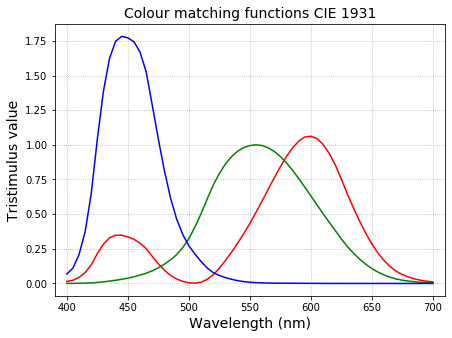

In [14]:
plt.figure(figsize=(7, 5))
plt.plot(grid, x, color='r')
plt.plot(grid, y, color='g')
plt.plot(grid, z, color='b')

plt.title('Colour matching functions CIE 1931', fontsize=14)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Tristimulus value', fontsize=14)
    
plt.xlim(390,710)
plt.grid(ls=':')
plt.show()

In [15]:
sqrt_x = []
sqrt_y = []
sqrt_z = []

for i in x: sqrt_x.append(math.sqrt(i))
for i in y: sqrt_y.append(math.sqrt(i))
for i in z: sqrt_z.append(math.sqrt(i))
    
sqrt_x = np.array(sqrt_x)
sqrt_y = np.array(sqrt_y)
sqrt_z = np.array(sqrt_z)

Пусть $R$ - матрица $m \times n$, где $m$ - число спектров поверхностного отражения в используемом наборе данных, а $n$ - число длин волн, использующихся для дискретизации (в нашем случае - 61). Взвешенная матрица данных может быть определена как:
$$ R_w = RW,$$
где $W$ - диагональная $n \times n$ матрица, на диагонали которой расположены значения весовой функции.

Применяя сингулярное разложение ко взевешнной матрице данных, получим:
$$R_w = U_w\Sigma_wV^T_w,$$
где индекс $w$ обозначает применение разложения ко взвешенным, а не оригинальным данным.

Реконструкцию спектральных данных при использовании весовой функции и $d$ главных компонент можно выразить как:
$$\hat{R} = (\tilde{V}_w^TC_w + \bar{R}_w)W^{-1},$$
где $\tilde{V}_w$ - первые $d$ столбцов унитарной матрицы $V$ из сингулярного разложения (базисные векторы), $C_w$ - столбец коэффициентов, $\bar{R}_w$ - среднее значение спектра во взвешенном наборе данных.

В работе Cao et al.(2016) были описаны следующие варианты весовых функций:
$$WF_1 = (\bar{x}(\lambda) + \bar{y}(\lambda) + \bar{z}(\lambda))\:/\:max(\bar{x}(\lambda) + \bar{y}(\lambda) + \bar{z}(\lambda))\\
WF_2 = (\bar{x}(\lambda) + \bar{y}(\lambda) + \bar{z}(\lambda) + 1)\:/\:max(\bar{x}(\lambda) + \bar{y}(\lambda) + \bar{z}(\lambda) + 1)\\
WF_3 = (\sqrt{\bar{x}(\lambda)} + \sqrt{\bar{y}(\lambda)} + \sqrt{\bar{z}(\lambda)})\:/\:max(\sqrt{\bar{x}(\lambda)} + \sqrt{\bar{y}(\lambda)} + \sqrt{\bar{z}(\lambda)})\\
WF_4 = (\sqrt{\bar{x}(\lambda)} + \sqrt{\bar{y}(\lambda)} + \sqrt{\bar{z}(\lambda)}) \times D_{65}\:/\:max((\sqrt{\bar{x}(\lambda)} + \sqrt{\bar{y}(\lambda)} + \sqrt{\bar{z}(\lambda)}) \times D_{65}),$$

где $\bar{x}(\lambda)$, $\bar{y}(\lambda)$, $\bar{z}(\lambda)$ - функции цветового захвата стандартного наблюдателя CIE 1931, $D_{65}$ - относительное спектральное распределение мощности стандратного осветителя CIE D65.

In [16]:
WF_1 = (x + y + z) / max(x + y + z)
WF_2 = (x + y + z + 1) / max(x + y + z +1)
WF_3 = (sqrt_x + sqrt_y + sqrt_z) / max(sqrt_x + sqrt_y + sqrt_z)
WF_4 = (sqrt_x + sqrt_y + sqrt_z) * D_65_relative / max((sqrt_x + sqrt_y + sqrt_z) * D_65_relative)

WF_1_matrix = np.diag(WF_1)
WF_2_matrix = np.diag(WF_2)
WF_3_matrix = np.diag(WF_3)
WF_4_matrix = np.diag(WF_4)

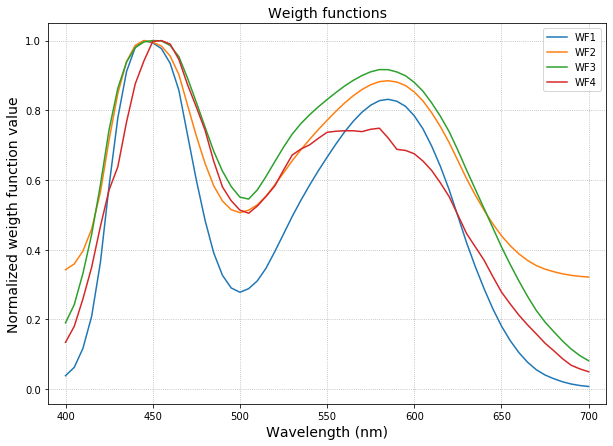

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(grid, WF_1, label='WF1')
plt.plot(grid, WF_2, label='WF2')
plt.plot(grid, WF_3, label='WF3')
plt.plot(grid, WF_4, label='WF4')

plt.title('Weigth functions', fontsize=14)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Normalized weigth function value', fontsize=14)
    
plt.xlim(390,710)
plt.grid(ls=':')
plt.legend()
plt.show()

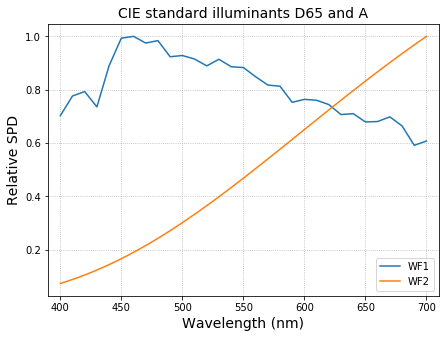

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(grid, D_65_relative, label='WF1')
plt.plot(grid, A_relative, label='WF2')

plt.title('CIE standard illuminants D65 and A', fontsize=14)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Relative SPD', fontsize=14)
    
plt.xlim(390,710)
plt.grid(ls=':')
plt.legend()
plt.show()

### Центрирование natural

In [19]:
natural_reflect_WF1 = natural_reflect @ WF_1_matrix
natural_reflect_WF2 = natural_reflect @ WF_2_matrix
natural_reflect_WF3 = natural_reflect @ WF_3_matrix
natural_reflect_WF4 = natural_reflect @ WF_4_matrix

In [20]:
mean_natural_reflect = natural_reflect.mean(axis=0).values
natural_reflect_centr = natural_reflect - mean_natural_reflect

mean_natural_reflect_WF1 = natural_reflect_WF1.mean(axis=0).values
natural_reflect_WF1_centr = natural_reflect_WF1 - mean_natural_reflect_WF1

mean_natural_reflect_WF2 = natural_reflect_WF2.mean(axis=0).values
natural_reflect_WF2_centr = natural_reflect_WF2 - mean_natural_reflect_WF2

mean_natural_reflect_WF3 = natural_reflect_WF3.mean(axis=0).values
natural_reflect_WF3_centr = natural_reflect_WF3 - mean_natural_reflect_WF3

mean_natural_reflect_WF4 = natural_reflect_WF4.mean(axis=0).values
natural_reflect_WF4_centr = natural_reflect_WF4 - mean_natural_reflect_WF4

### Центрирование munsell

In [21]:
munsell_reflect_WF1 = munsell_reflect @ WF_1_matrix
munsell_reflect_WF2 = munsell_reflect @ WF_2_matrix
munsell_reflect_WF3 = munsell_reflect @ WF_3_matrix
munsell_reflect_WF4 = munsell_reflect @ WF_4_matrix

In [22]:
mean_munsell_reflect = munsell_reflect.mean(axis=0).values
munsell_reflect_centr = munsell_reflect - mean_munsell_reflect

mean_munsell_reflect_WF1 = munsell_reflect_WF1.mean(axis=0).values
munsell_reflect_WF1_centr = munsell_reflect_WF1 - mean_munsell_reflect_WF1

mean_munsell_reflect_WF2 = munsell_reflect_WF2.mean(axis=0).values
munsell_reflect_WF2_centr = munsell_reflect_WF2 - mean_munsell_reflect_WF2

mean_munsell_reflect_WF3 = munsell_reflect_WF3.mean(axis=0).values
munsell_reflect_WF3_centr = munsell_reflect_WF3 - mean_munsell_reflect_WF3

mean_munsell_reflect_WF4 = munsell_reflect_WF4.mean(axis=0).values
munsell_reflect_WF4_centr = munsell_reflect_WF4 - mean_munsell_reflect_WF4

In [23]:
from sklearn.decomposition import PCA

pca_standard = PCA().fit(munsell_reflect_centr)
pca_WF1 = PCA().fit(munsell_reflect_WF1_centr)
pca_WF2 = PCA().fit(munsell_reflect_WF2_centr)
pca_WF3 = PCA().fit(munsell_reflect_WF3_centr)
pca_WF4 = PCA().fit(munsell_reflect_WF4_centr)

### Обзор собственных значений

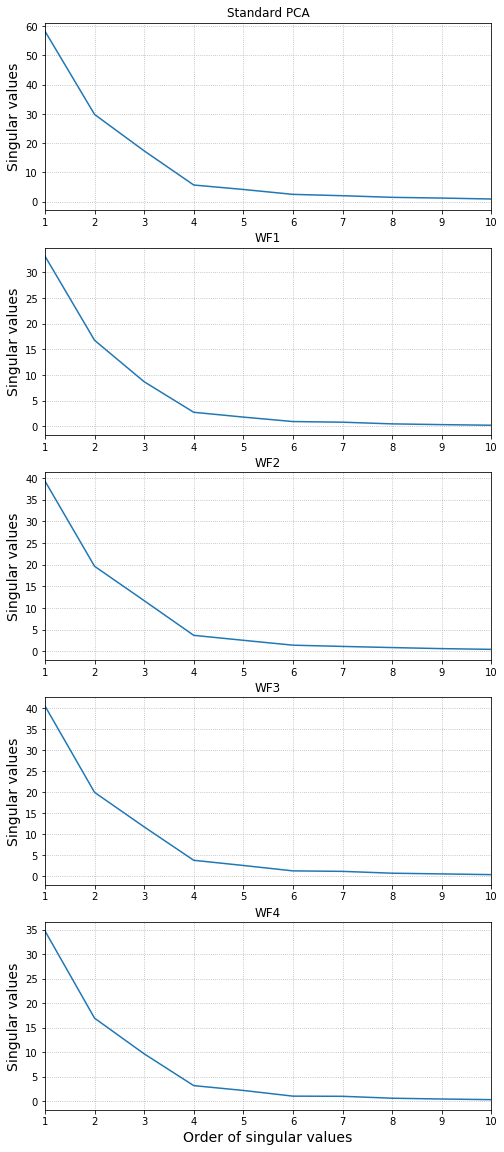

In [24]:
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

pca_versions = [pca_standard, pca_WF1, pca_WF2, pca_WF3, pca_WF4]
plt_grid = np.linspace(1, 61, 61)

for i, ax in zip(range(5), axs.reshape(-1)):
    ax.plot(plt_grid, pca_versions[i].singular_values_)
    ax.set_xlim(1, 10)
    ax.grid(ls=':')
    if i == 0:
        ax.set_title('Standard PCA')
    else:
        ax.set_title('WF{}'.format(i))
    ax.set_ylabel('Singular values', fontsize=14)

axs[4].set_xlabel('Order of singular values', fontsize=14)
plt.show()

### Дополнительные тестовые данные (пригодятся потом)

In [25]:
with open('forest390_850_5/birch.json', 'r') as read_file:
    birch = json.load(read_file)
    
with open('forest390_850_5/pine.json', 'r') as read_file:
    pine = json.load(read_file)

with open('forest390_850_5/spruce.json', 'r') as read_file:
    spruce = json.load(read_file)

In [26]:
delete_column_birch = []
for i in birch['lambdas']:
    if i not in grid:
        delete_column_birch.append(i)
        
delete_column_pine = []
for i in pine['lambdas']:
    if i not in grid:
        delete_column_pine.append(i)
        
delete_column_spruce = []
for i in spruce['lambdas']:
    if i not in grid:
        delete_column_spruce.append(i)

In [27]:
birch_reflect = np.array([birch['lambdas']])
for key in birch['data'].keys():
    birch_reflect = np.concatenate(( birch_reflect, np.array([birch['data'][key]]) ), axis=0)   
birch_reflect = np.delete(birch_reflect, 0, 0)
birch_reflect =  pd.DataFrame(birch_reflect, columns=birch['lambdas'])
birch_reflect = birch_reflect.drop(columns=delete_column_birch)

pine_reflect = np.array([pine['lambdas']])
for key in pine['data'].keys():
    pine_reflect = np.concatenate(( pine_reflect, np.array([pine['data'][key]]) ), axis=0)   
pine_reflect = np.delete(pine_reflect, 0, 0)
pine_reflect =  pd.DataFrame(pine_reflect, columns=pine['lambdas'])
pine_reflect = pine_reflect.drop(columns=delete_column_pine)

spruce_reflect = np.array([spruce['lambdas']])
for key in spruce['data'].keys():
    spruce_reflect = np.concatenate(( spruce_reflect, np.array([spruce['data'][key]]) ), axis=0)   
spruce_reflect = np.delete(spruce_reflect, 0, 0)
spruce_reflect =  pd.DataFrame(spruce_reflect, columns=spruce['lambdas'])
spruce_reflect = spruce_reflect.drop(columns=delete_column_spruce)

In [28]:
birch_reflect.shape, pine_reflect.shape, spruce_reflect.shape

((337, 61), (370, 61), (349, 61))

In [29]:
NCS_forest_reflect = pd.concat([birch_reflect, pine_reflect, spruce_reflect, natural_reflect])
NCS_forest_reflect.shape

(1239, 61)

In [30]:
NCS_forest_reflect.index = np.arange(0, NCS_forest_reflect.shape[0])

In [31]:
NCS_forest_reflect

,400,405,410,415,420,425,430,435,440,445,...,655,660,665,670,675,680,685,690,695,700
0,0.013063,0.017837,0.017537,0.019046,0.019097,0.017793,0.019848,0.018711,0.020139,0.022376,...,0.030895,0.029861,0.028224,0.027169,0.029242,0.030518,0.032985,0.043968,0.061645,0.083848
1,0.019952,0.015524,0.018081,0.022808,0.019297,0.019498,0.019641,0.021912,0.022353,0.021892,...,0.034150,0.033031,0.031086,0.031638,0.032436,0.032034,0.038473,0.048002,0.063051,0.085902
2,0.022524,0.023150,0.022020,0.021323,0.022747,0.023402,0.022831,0.023745,0.022778,0.024143,...,0.032378,0.031428,0.031510,0.030885,0.031760,0.034199,0.036382,0.047565,0.065917,0.089160
3,0.019181,0.019231,0.016420,0.019025,0.020250,0.019050,0.021686,0.021825,0.022558,0.022567,...,0.035579,0.033481,0.033733,0.032317,0.032418,0.033873,0.039432,0.050521,0.065492,0.090173
4,0.019168,0.022344,0.024112,0.022959,0.023563,0.021745,0.023982,0.024446,0.022965,0.024329,...,0.032874,0.032912,0.031421,0.029669,0.030943,0.033198,0.038470,0.045971,0.061699,0.084565
5,0.022475,0.018364,0.021900,0.020002,0.020810,0.021740,0.020909,0.024825,0.024873,0.024179,...,0.035771,0.036023,0.033925,0.032812,0.034218,0.036555,0.043592,0.054719,0.073374,0.101550
6,0.025370,0.029408,0.028830,0.028312,0.028507,0.026855,0.031050,0.030483,0.032270,0.034204,...,0.053009,0.050111,0.047287,0.047780,0.045057,0.047973,0.059885,0.073921,0.101475,0.136764
7,0.021167,0.018870,0.017502,0.016985,0.020774,0.023731,0.019521,0.020520,0.022762,0.021774,...,0.037073,0.035373,0.032647,0.031922,0.034226,0.035851,0.041866,0.055681,0.079608,0.110381
8,0.016039,0.018757,0.023203,0.017537,0.020515,0.023432,0.024861,0.024582,0.024304,0.023318,...,0.040039,0.038080,0.035301,0.033560,0.034597,0.038255,0.047561,0.061773,0.089216,0.125559
9,0.015902,0.014311,0.016427,0.017472,0.017753,0.016077,0.016378,0.016940,0.017178,0.017858,...,0.025859,0.024568,0.023460,0.023649,0.024124,0.024529,0.029366,0.038521,0.054548,0.074819


In [32]:
NCS_forest_reflect_WF1 = NCS_forest_reflect @ WF_1_matrix
NCS_forest_reflect_WF2 = NCS_forest_reflect @ WF_2_matrix
NCS_forest_reflect_WF3 = NCS_forest_reflect @ WF_3_matrix
NCS_forest_reflect_WF4 = NCS_forest_reflect @ WF_4_matrix

In [33]:
mean_NCS_forest_reflect = NCS_forest_reflect.mean(axis=0).values
NCS_forest_reflect_centr = NCS_forest_reflect - mean_NCS_forest_reflect

mean_NCS_forest_reflect_WF1 = NCS_forest_reflect_WF1.mean(axis=0).values
NCS_forest_reflect_WF1_centr = NCS_forest_reflect_WF1 - mean_NCS_forest_reflect_WF1

mean_NCS_forest_reflect_WF2 = NCS_forest_reflect_WF2.mean(axis=0).values
NCS_forest_reflect_WF2_centr = NCS_forest_reflect_WF2 - mean_NCS_forest_reflect_WF2

mean_NCS_forest_reflect_WF3 = NCS_forest_reflect_WF3.mean(axis=0).values
NCS_forest_reflect_WF3_centr = NCS_forest_reflect_WF3 - mean_NCS_forest_reflect_WF3

mean_NCS_forest_reflect_WF4 = NCS_forest_reflect_WF4.mean(axis=0).values
NCS_forest_reflect_WF4_centr = NCS_forest_reflect_WF4 - mean_NCS_forest_reflect_WF4

### Спектральная реконструкция

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [35]:
def get_approximation(pca_version, num_components, test_type, precalc):
    pca = PCA(n_components=num_components)
    
    if pca_version == 'standard':
        pca = pca.fit(munsell_reflect_centr)
        mean_reflect = mean_munsell_reflect
        WF_inverse = np.identity(len(grid))
        
        reflect_centr_mun = munsell_reflect_centr
        reflect_centr_nat = natural_reflect_centr
        reflect_centr_forest = NCS_forest_reflect_centr
        
    elif pca_version == 'WF1':
        pca = pca.fit(munsell_reflect_WF1_centr)
        mean_reflect = mean_munsell_reflect_WF1
        WF_inverse = np.linalg.inv(WF_1_matrix)
        
        reflect_centr_mun = munsell_reflect_WF1_centr
        reflect_centr_nat = natural_reflect_WF1_centr
        reflect_centr_forest = NCS_forest_reflect_WF1_centr
        
    elif pca_version == 'WF2':
        pca = pca.fit(munsell_reflect_WF2_centr)
        mean_reflect = mean_munsell_reflect_WF2
        WF_inverse = np.linalg.inv(WF_2_matrix)
        
        reflect_centr_mun = munsell_reflect_WF2_centr
        reflect_centr_nat = natural_reflect_WF2_centr
        reflect_centr_forest = NCS_forest_reflect_WF2_centr
        
    elif pca_version == 'WF3':
        pca = pca.fit(munsell_reflect_WF3_centr)
        mean_reflect = mean_munsell_reflect_WF3
        WF_inverse = np.linalg.inv(WF_3_matrix)
        
        reflect_centr_mun = munsell_reflect_WF3_centr
        reflect_centr_nat = natural_reflect_WF3_centr
        reflect_centr_forest = NCS_forest_reflect_WF3_centr
        
    elif pca_version == 'WF4':
        pca = pca.fit(munsell_reflect_WF4_centr)
        mean_reflect = mean_munsell_reflect_WF4
        WF_inverse = np.linalg.inv(WF_4_matrix)
        
        reflect_centr_mun = munsell_reflect_WF4_centr
        reflect_centr_nat = natural_reflect_WF4_centr
        reflect_centr_forest = NCS_forest_reflect_WF4_centr
        
    if test_type == 'natural':
        if precalc:
            reflect_centr = natural_reflect -  mean_reflect # используем предподсчитанное на обучении среднее
        else:
            reflect_centr = reflect_centr_nat # не используем предподсчитанное среднее
    elif test_type == 'forest':
        if precalc:
            reflect_centr = NCS_forest_reflect - mean_reflect
        else:
            reflect_centr = reflect_centr_forest
    elif test_type == 'munsell':
        reflect_centr = reflect_centr_mun

    reflect_transform = pca.transform(reflect_centr)
    return (pca.inverse_transform(reflect_transform) + mean_reflect) @ WF_inverse

In [36]:
def set_approximations(test_type, precalc=True):
    approxs = []
    for num_components in range(3, 9):
        approxs.append([get_approximation('standard', num_components, test_type, precalc),
                        get_approximation('WF1', num_components, test_type, precalc),
                        get_approximation('WF2', num_components, test_type, precalc),
                        get_approximation('WF3', num_components, test_type, precalc),
                        get_approximation('WF4', num_components, test_type, precalc)])
    return np.array(approxs)

In [37]:
def plot_approximation(num_components, num_spectrum, approximations, type_test):
    pca_versions_name = ['Standard', 'WF1', 'WF2', 'WF3', 'WF4']
    
    if type_test == 'munsell':
        true = munsell_reflect.loc[num_spectrum].values
    elif type_test == 'natural':
        true = natural_reflect.loc[num_spectrum].values
        
    fig, axs = plt.subplots(5, figsize=(8, 20))
    # iterations over pca versions
    for i, ax in zip(range(5), axs.reshape(-1)):
        approx = approximations[num_components-3][i][num_spectrum]
        
        if i == 0:
            ax.plot(grid, true, label='Original')
            ax.plot(grid, approx, '--', color='r', label='Approximation')
        else:
            ax.plot(grid, true)
            ax.plot(grid, approx, '--', color='r')
        ax.set_title(pca_versions_name[i], fontsize=12)
        ax.set_ylabel('Reflectance', fontsize=12)
        ax.grid(ls=':')
        print(pca_versions_name[i] + ' PCA, RMSE: ', round(math.sqrt(mean_squared_error(true, approx)), 5))
                 
    axs[4].set_xlabel('Wavelength (nm)', fontsize=12)            
    fig.suptitle('Reflectance spectrum from ' + type_test + ' set №{}'.format(num_spectrum), fontsize=14)
    fig.legend()
    plt.show()

In [38]:
approximations_munsell = set_approximations('munsell')
approximations_natural_precalc = set_approximations('natural', precalc=True)
approximations_natural = set_approximations('natural', precalc=False)

# (num_components, pca_version, num_spectra, discretization)
approximations_munsell.shape, approximations_natural.shape

((6, 5, 1600, 61), (6, 5, 183, 61))

Standard PCA, RMSE:  0.0033
WF1 PCA, RMSE:  0.00665
WF2 PCA, RMSE:  0.00438
WF3 PCA, RMSE:  0.00584
WF4 PCA, RMSE:  0.00642


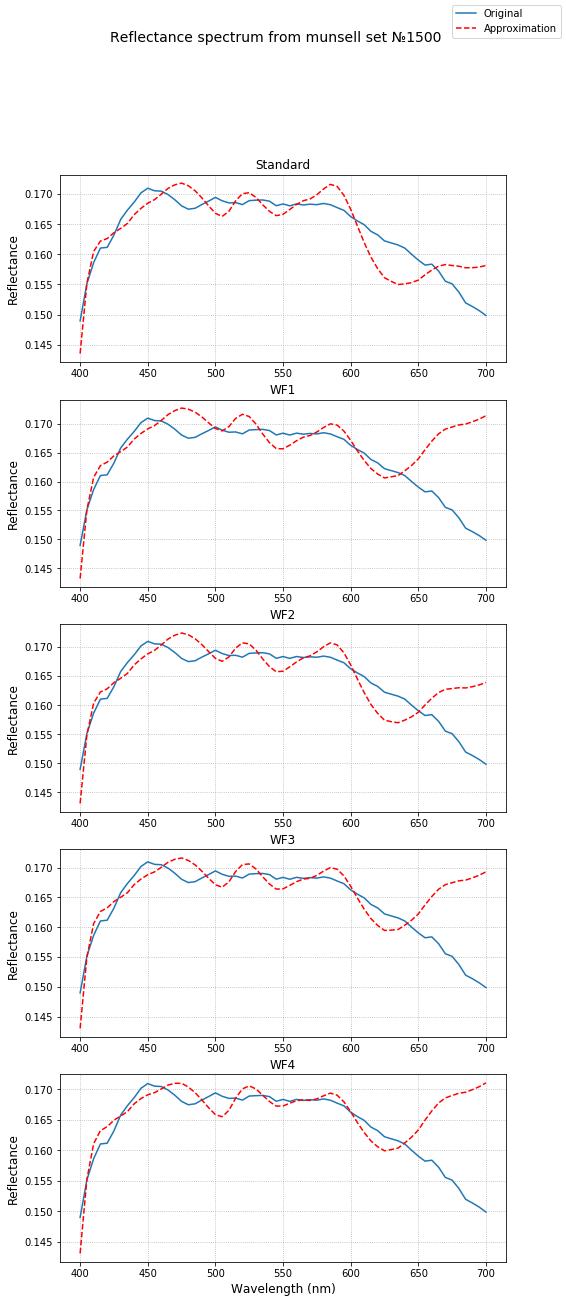

In [39]:
plot_approximation(4, 1500, approximations_munsell, 'munsell')

Standard PCA, RMSE:  0.0694
WF1 PCA, RMSE:  0.07383
WF2 PCA, RMSE:  0.07217
WF3 PCA, RMSE:  0.07152
WF4 PCA, RMSE:  0.07105


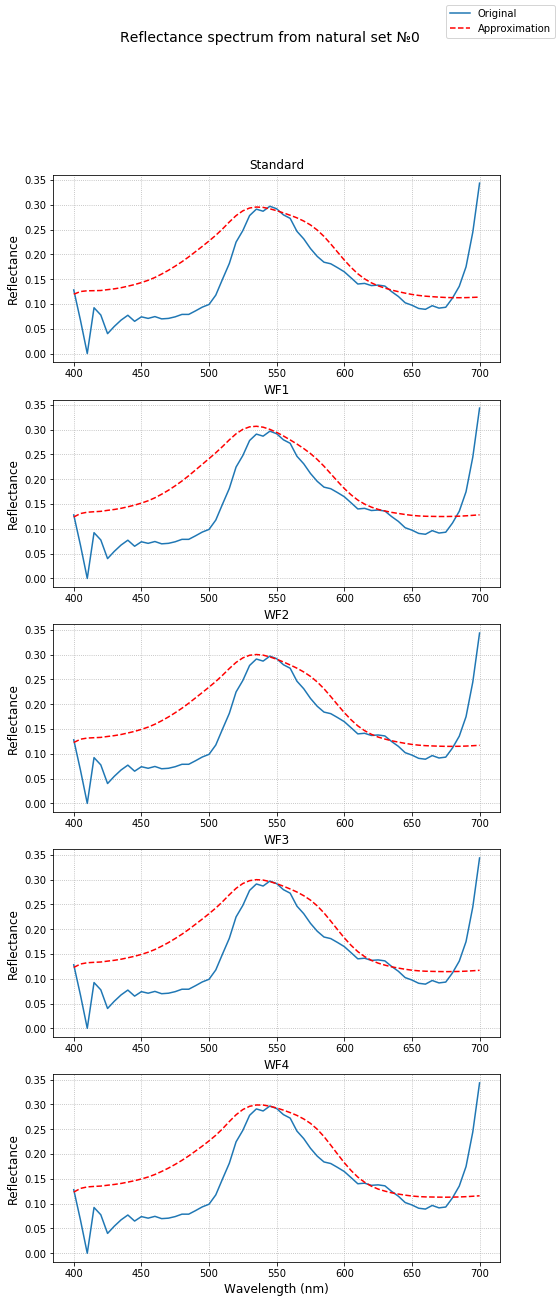

In [40]:
plot_approximation(4, 0, approximations_natural, 'natural')

Standard PCA, RMSE:  0.04255
WF1 PCA, RMSE:  0.14927
WF2 PCA, RMSE:  0.10187
WF3 PCA, RMSE:  0.07785
WF4 PCA, RMSE:  0.11412


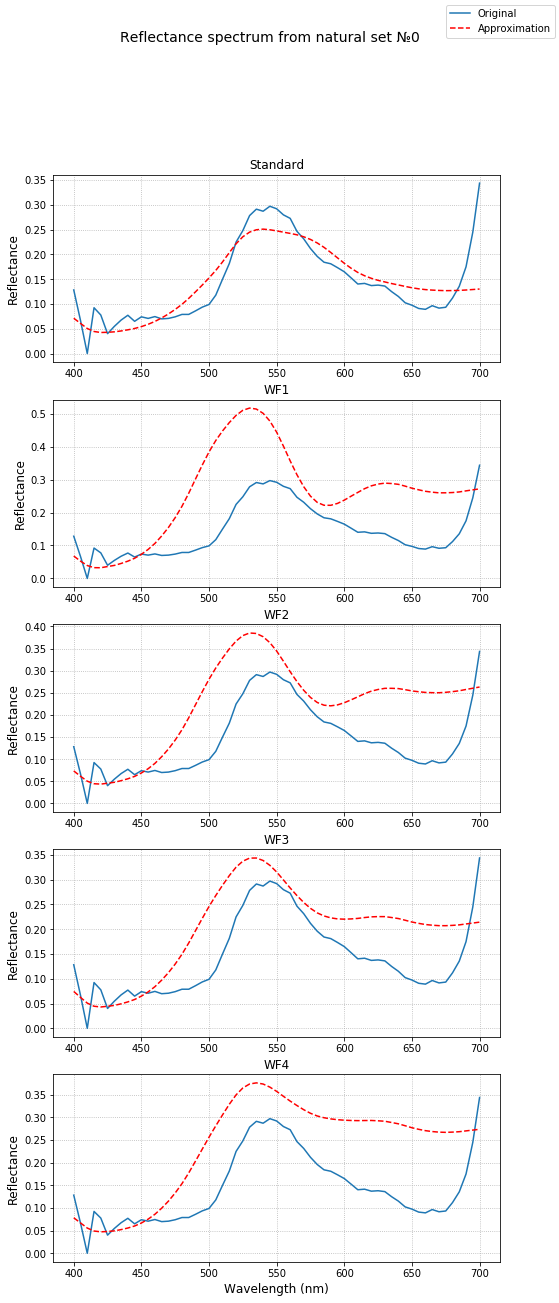

In [41]:
plot_approximation(4, 0, approximations_natural_precalc, 'natural')

### Исследование ошибок спектральной реконструкции

In [42]:
def get_spectra_errors(approximations, true_spectra):
    spectra_errors = []
    
    for i in range(len(approximations)):
        errors_spectra_pca_versions = []
        
        for j in range(len(approximations[i])): # итерация по версиям PCA
            errors_separate_spectra = []
            
            for k in range(len(approximations[i][j])): # итерация по спектрам
                errors_separate_spectra.append(sqrt(
                    mean_squared_error(true_spectra.loc[k].values, approximations[i][j][k])))

            errors_spectra_pca_versions.append(np.array(errors_separate_spectra).mean())
        spectra_errors.append(errors_spectra_pca_versions)
        
    return np.array(spectra_errors)

In [43]:
#Mean RMSE for approximations of different versions of PCA
#for Munsell set, Natural set & Natural set with training precalc

errors_munsell = get_spectra_errors(approximations_munsell, munsell_reflect)
errors_natural = get_spectra_errors(approximations_natural, natural_reflect)
errors_natural_precalc = get_spectra_errors(approximations_natural_precalc, natural_reflect)

In [44]:
all_errors = np.concatenate((errors_munsell, errors_natural, errors_natural_precalc), axis=1)
all_errors = pd.DataFrame(all_errors, index=np.arange(3, 9),
                      columns=[('RMSE Munsell', 'PCA'),('RMSE Munsell', 'WF1'),('RMSE Munsell', 'WF2'),
                               ('RMSE Munsell', 'WF3'),('RMSE Munsell', 'WF4'),
                               ('RMSE NCS', 'PCA'),('RMSE NCS', 'WF1'),('RMSE NCS', 'WF2'),
                               ('RMSE NCS', 'WF3'),('RMSE NCS', 'WF4'),
                               ('RMSE NCS (Centered by Munsell Set)', 'PCA'),
                               ('RMSE NCS (Centered by Munsell Set)', 'WF1'),
                               ('RMSE NCS (Centered by Munsell Set)', 'WF2'),
                               ('RMSE NCS (Centered by Munsell Set)', 'WF3'),
                               ('RMSE NCS (Centered by Munsell Set)', 'WF4')])
all_errors.columns = pd.MultiIndex.from_tuples(all_errors.columns)

In [45]:
all_errors

RMSE Munsell                                          RMSE NCS            \
           PCA       WF1       WF2       WF3       WF4       PCA       WF1   
3     0.021134  0.026510  0.022945  0.024092  0.024941  0.072012  0.076329   
4     0.014436  0.018955  0.015725  0.016939  0.017557  0.070087  0.074778   
5     0.010574  0.015060  0.011600  0.013047  0.013577  0.068179  0.073226   
6     0.008268  0.012668  0.008966  0.010542  0.012275  0.066694  0.071490   
7     0.006289  0.011220  0.007254  0.009135  0.009606  0.064806  0.070522   
8     0.005022  0.009916  0.005636  0.007457  0.008237  0.064276  0.069756   

                                RMSE NCS (Centered by Munsell Set)            \
        WF2       WF3       WF4                                PCA       WF1   
3  0.073412  0.074761  0.075345                           0.044189  0.160540   
4  0.071383  0.072991  0.073501                           0.040879  0.274643   
5  0.069448  0.071198  0.071776                           0.035293  0.292494   
6  0.067543  0.069102  0.070904                           0.032282  0.387356   
7  0.066287  0.068140  0.068655                           0.028277  0.457889   
8  0.065419  0.066747  0.067534                           0.026987  0.498150   

                                 
        WF2       WF3       WF4  
3  0.160390  0.133022  0.230292  
4  0.213251  0.177350  0.286793  
5  0.237270  0.207942  0.333485  
6  0.296181  0.294286  0.332416  
7  0.302610  0.313427  0.482414  
8  0.314276  0.375568  0.510367

Построим графики зависимости рассчитанных ошибок от числа компонент.

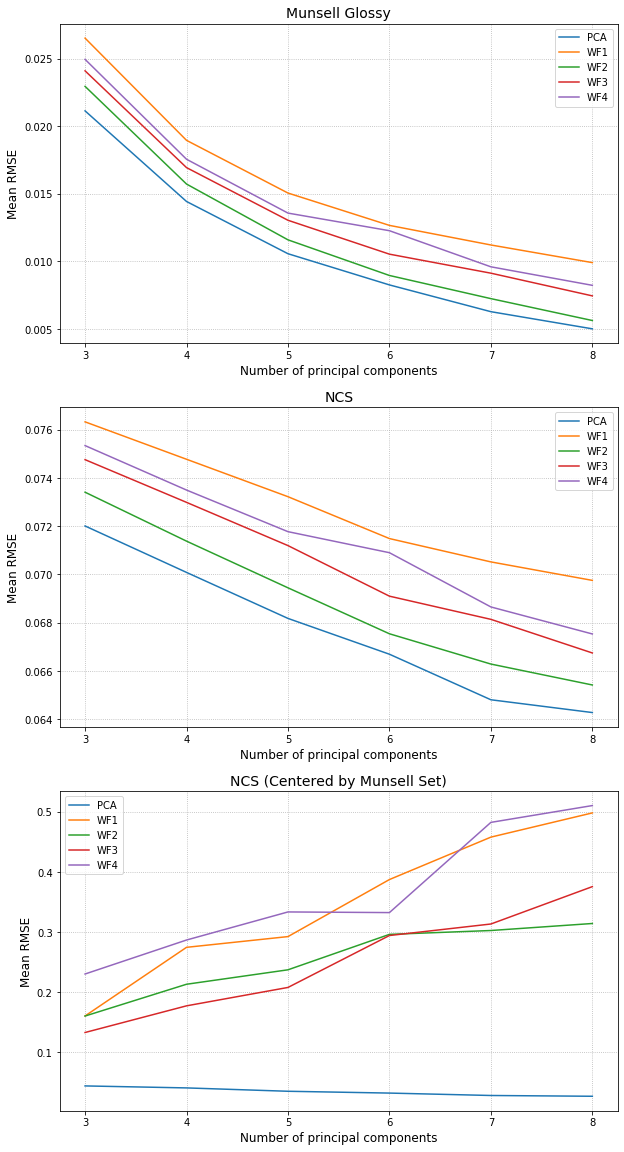

In [46]:
fig, axs = plt.subplots(3, 1, figsize=(10, 20))

approx_versions = ['RMSE Munsell', 'RMSE NCS', 'RMSE NCS (Centered by Munsell Set)']
titles = ['Munsell Glossy', 'NCS', 'NCS (Centered by Munsell Set)']

for i, ax in zip(range(3), axs.reshape(-1)):
    ax.plot(all_errors.index, all_errors[approx_versions[i]]['PCA'].values, label='PCA')
    ax.plot(all_errors.index, all_errors[approx_versions[i]]['WF1'].values, label='WF1')
    ax.plot(all_errors.index, all_errors[approx_versions[i]]['WF2'].values, label='WF2')
    ax.plot(all_errors.index, all_errors[approx_versions[i]]['WF3'].values, label='WF3')
    ax.plot(all_errors.index, all_errors[approx_versions[i]]['WF4'].values, label='WF4')
    
    ax.set_title(titles[i], fontsize=14)
    ax.grid(ls=':')
    ax.set_ylabel('Mean RMSE', fontsize=12)
    ax.set_xlabel('Number of principal components', fontsize=12)
    ax.legend()

plt.show()

### Колориметрическая реконструкция

In [47]:
def get_XYZ(real_spectra, illuminant):    
    XYZ = []

    for i in range(real_spectra.shape[0]):
        XYZ.append(
            (matching.T @ np.diag(illuminant) @ real_spectra.loc[i].values).values)
    return np.array(XYZ)

In [48]:
def get_XYZ_approx(approximations, illuminant):
    XYZ_approx = []
    
    for i in range(len(approximations)): #итерация по числу компонент
        XYZ_approx_pca_versions = []

        for j in range(len(approximations[i])): # итерация по версиям PCA
            XYZ_approx_separate_color = []

            for k in range(len(approximations[i][j])): # итерация по спектрам
                XYZ_approx_separate_color.append((
                    matching.T @ np.diag(illuminant) @ approximations[i][j][k]).values)
            XYZ_approx_pca_versions.append(XYZ_approx_separate_color)
            
        XYZ_approx.append(XYZ_approx_pca_versions)
    return np.array(XYZ_approx)

In [49]:
XYZ_munsell_D65 = get_XYZ(munsell_reflect, D_65)
XYZ_munsell_A = get_XYZ(munsell_reflect, A)

XYZ_NCS_D65 = get_XYZ(natural_reflect, D_65)
XYZ_NCS_A = get_XYZ(natural_reflect, A)

In [50]:
XYZ_munsell_D_65_approx = get_XYZ_approx(approximations_munsell, D_65)
XYZ_munsell_A_approx = get_XYZ_approx(approximations_munsell, A)

XYZ_natural_D_65_approx = get_XYZ_approx(approximations_natural, D_65)
XYZ_natural_A_approx = get_XYZ_approx(approximations_natural, A)

XYZ_natural_precalc_D_65_approx = get_XYZ_approx(approximations_natural_precalc, D_65)
XYZ_natural_precalc_A_approx = get_XYZ_approx(approximations_natural_precalc, A)

### Исследование ошибок колориметрической реконструкции

In [51]:
from colormath.color_objects import LabColor, XYZColor
from colormath.color_conversions import convert_color

from colormath.color_diff import delta_e_cie1976
from colormath.color_diff import delta_e_cie2000

In [52]:
def get_Lab(XYZ, illum):
    Lab = []

    for i in range(len(XYZ)):
        xyz = XYZColor(XYZ[i][0], 
                       XYZ[i][1], 
                       XYZ[i][2], illuminant=illum)
        Lab.append(convert_color(xyz, LabColor, 
                                 target_illuminant=illum))
    return np.array(Lab)

In [53]:
def get_Lab_approx(XYZ_approx, illum):
    Lab_approx = []
    
    for i in range(len(XYZ_approx)):
        Lab_approx_pca_versions = []
        
        for j in range(len(XYZ_approx[i])):
            Lab_approx_separate_color = []
            
            for k in range(len(XYZ_approx[i][j])):
                xyz = XYZColor(XYZ_approx[i][j][k][0], 
                               XYZ_approx[i][j][k][1], 
                               XYZ_approx[i][j][k][2], illuminant=illum)
                Lab_approx_separate_color.append(convert_color(xyz, LabColor, 
                                                    target_illuminant=illum))
            Lab_approx_pca_versions.append(Lab_approx_separate_color)
        Lab_approx.append(Lab_approx_pca_versions)
    return np.array(Lab_approx)

In [54]:
# конвертация XYZ --> Lab
Lab_munsell_D65 = get_Lab(XYZ_munsell_D65, 'd65')
Lab_munsell_A = get_Lab(XYZ_munsell_A, 'a')

Lab_NCS_D65 = get_Lab(XYZ_NCS_D65, 'd65')
Lab_NCS_A = get_Lab(XYZ_NCS_A, 'a')

In [55]:
Lab_munsell_D_65_approx = get_Lab_approx(XYZ_munsell_D_65_approx, 'd65')
Lab_munsell_A_approx = get_Lab_approx(XYZ_munsell_A_approx, 'a')

Lab_natural_D_65_approx = get_Lab_approx(XYZ_natural_D_65_approx, 'd65')
Lab_natural_A_approx = get_Lab_approx(XYZ_natural_A_approx, 'a')

Lab_natural_precalc_D_65_approx = get_Lab_approx(XYZ_natural_precalc_D_65_approx, 'd65')
Lab_natural_precalc_A_approx = get_Lab_approx(XYZ_natural_precalc_A_approx, 'a')

In [56]:
def get_delta_E(Lab_approximations, Lab_true, delta_E_version):
    delta_E = []
    
    for i in range(len(Lab_approximations)):
        delta_E_pca_versions = []
        
        for j in range(len(Lab_approximations[i])): # итерация по версиям PCA
            delta_E_separate_color = []
            
            for k in range(len(Lab_approximations[i][j])):
                if delta_E_version == '1976':
                    delta_E_separate_color.append(delta_e_cie1976(Lab_approximations[i][j][k], Lab_true[k]))
                if delta_E_version == '2000':
                    delta_E_separate_color.append(delta_e_cie2000(Lab_approximations[i][j][k], Lab_true[k]))
                    
            delta_E_pca_versions.append(np.array(delta_E_separate_color).mean())
        delta_E.append(delta_E_pca_versions)
    return np.array(delta_E)

In [57]:
munsell_D65_delta_E_1976 = get_delta_E(Lab_munsell_D_65_approx, Lab_munsell_D65, '1976')
munsell_A_delta_E_1976 = get_delta_E(Lab_munsell_A_approx, Lab_munsell_A, '1976')

NCS_D65_delta_E_1976 = get_delta_E(Lab_natural_D_65_approx, Lab_NCS_D65, '1976')
NCS_A_delta_E_1976 = get_delta_E(Lab_natural_A_approx, Lab_NCS_A, '1976')

NCS_precalc_D65_delta_E_1976 = get_delta_E(Lab_natural_precalc_D_65_approx, Lab_NCS_D65, '1976')
NCS_precalc_A_delta_E_1976 = get_delta_E(Lab_natural_precalc_A_approx, Lab_NCS_A, '1976')

In [58]:
munsell_D65_delta_E_2000 = get_delta_E(Lab_munsell_D_65_approx, Lab_munsell_D65, '2000')
munsell_A_delta_E_2000 = get_delta_E(Lab_munsell_A_approx, Lab_munsell_A, '2000')

NCS_D65_delta_E_2000 = get_delta_E(Lab_natural_D_65_approx, Lab_NCS_D65, '2000')
NCS_A_delta_E_2000 = get_delta_E(Lab_natural_A_approx, Lab_NCS_A, '2000')

NCS_precalc_D65_delta_E_2000 = get_delta_E(Lab_natural_precalc_D_65_approx, Lab_NCS_D65, '2000')
NCS_precalc_A_delta_E_2000 = get_delta_E(Lab_natural_precalc_A_approx, Lab_NCS_A, '2000')

In [59]:
munsell_delta_E = np.concatenate((munsell_D65_delta_E_1976, munsell_A_delta_E_1976), axis=1)
munsell_delta_E = pd.DataFrame(munsell_delta_E, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 76 (D65)', 'PCA'),('Mean ΔE CIE 76 (D65)', 'WF1'),
                               ('Mean ΔE CIE 76 (D65)', 'WF2'),('Mean ΔE CIE 76 (D65)', 'WF3'),
                               ('Mean ΔE CIE 76 (D65)', 'WF4'),('Mean ΔE CIE 76 (A)', 'PCA'),
                               ('Mean ΔE CIE 76 (A)', 'WF1'),('Mean ΔE CIE 76 (A)', 'WF2'),
                               ('Mean ΔE CIE 76 (A)', 'WF3'),('Mean ΔE CIE 76 (A)', 'WF4')])
munsell_delta_E.columns = pd.MultiIndex.from_tuples(munsell_delta_E.columns)

In [60]:
NCS_delta_E = np.concatenate((NCS_D65_delta_E_1976, NCS_A_delta_E_1976), axis=1)
NCS_delta_E = pd.DataFrame(NCS_delta_E, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 76 (D65)', 'PCA'),('Mean ΔE CIE 76 (D65)', 'WF1'),
                               ('Mean ΔE CIE 76 (D65)', 'WF2'),('Mean ΔE CIE 76 (D65)', 'WF3'),
                               ('Mean ΔE CIE 76 (D65)', 'WF4'),('Mean ΔE CIE 76 (A)', 'PCA'),
                               ('Mean ΔE CIE 76 (A)', 'WF1'),('Mean ΔE CIE 76 (A)', 'WF2'),
                               ('Mean ΔE CIE 76 (A)', 'WF3'),('Mean ΔE CIE 76 (A)', 'WF4')])
NCS_delta_E.columns = pd.MultiIndex.from_tuples(NCS_delta_E.columns)

In [61]:
NCS_precalc_delta_E = np.concatenate((NCS_precalc_D65_delta_E_1976, NCS_precalc_A_delta_E_1976), axis=1)
NCS_precalc_delta_E = pd.DataFrame(NCS_precalc_delta_E, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 76 (D65)', 'PCA'),('Mean ΔE CIE 76 (D65)', 'WF1'),
                               ('Mean ΔE CIE 76 (D65)', 'WF2'),('Mean ΔE CIE 76 (D65)', 'WF3'),
                               ('Mean ΔE CIE 76 (D65)', 'WF4'),('Mean ΔE CIE 76 (A)', 'PCA'),
                               ('Mean ΔE CIE 76 (A)', 'WF1'),('Mean ΔE CIE 76 (A)', 'WF2'),
                               ('Mean ΔE CIE 76 (A)', 'WF3'),('Mean ΔE CIE 76 (A)', 'WF4')])
NCS_precalc_delta_E.columns = pd.MultiIndex.from_tuples(NCS_precalc_delta_E.columns)

In [62]:
munsell_delta_E_2000 = np.concatenate((munsell_D65_delta_E_2000, munsell_A_delta_E_2000), axis=1)
munsell_delta_E_2000 = pd.DataFrame(munsell_delta_E_2000, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 2000 (D65)', 'PCA'),('Mean ΔE CIE 2000 (D65)', 'WF1'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF2'),('Mean ΔE CIE 2000 (D65)', 'WF3'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF4'),('Mean ΔE CIE 2000 (A)', 'PCA'),
                               ('Mean ΔE CIE 2000 (A)', 'WF1'),('Mean ΔE CIE 2000 (A)', 'WF2'),
                               ('Mean ΔE CIE 2000 (A)', 'WF3'),('Mean ΔE CIE 2000 (A)', 'WF4')])
munsell_delta_E_2000.columns = pd.MultiIndex.from_tuples(munsell_delta_E_2000.columns)

In [63]:
NCS_delta_E_2000 = np.concatenate((NCS_D65_delta_E_2000, NCS_A_delta_E_2000), axis=1)
NCS_delta_E_2000 = pd.DataFrame(NCS_delta_E_2000, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 2000 (D65)', 'PCA'),('Mean ΔE CIE 2000 (D65)', 'WF1'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF2'),('Mean ΔE CIE 2000 (D65)', 'WF3'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF4'),('Mean ΔE CIE 2000 (A)', 'PCA'),
                               ('Mean ΔE CIE 2000 (A)', 'WF1'),('Mean ΔE CIE 2000 (A)', 'WF2'),
                               ('Mean ΔE CIE 2000 (A)', 'WF3'),('Mean ΔE CIE 2000 (A)', 'WF4')])
NCS_delta_E_2000.columns = pd.MultiIndex.from_tuples(NCS_delta_E_2000.columns)

In [64]:
NCS_precalc_delta_E_2000 = np.concatenate((NCS_precalc_D65_delta_E_2000, NCS_precalc_A_delta_E_2000), axis=1)
NCS_precalc_delta_E_2000 = pd.DataFrame(NCS_precalc_delta_E_2000, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 2000 (D65)', 'PCA'),('Mean ΔE CIE 2000 (D65)', 'WF1'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF2'),('Mean ΔE CIE 2000 (D65)', 'WF3'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF4'),('Mean ΔE CIE 2000 (A)', 'PCA'),
                               ('Mean ΔE CIE 2000 (A)', 'WF1'),('Mean ΔE CIE 2000 (A)', 'WF2'),
                               ('Mean ΔE CIE 2000 (A)', 'WF3'),('Mean ΔE CIE 2000 (A)', 'WF4')])
NCS_precalc_delta_E_2000.columns = pd.MultiIndex.from_tuples(NCS_precalc_delta_E_2000.columns)

In [65]:
munsell_delta_E

Mean ΔE CIE 76 (D65)                                              \
                   PCA        WF1        WF2        WF3        WF4   
3            48.776540  37.623003  39.065721  30.915317  21.752613   
4            21.144426  13.810725   6.691742   4.066266   3.106071   
5            11.276947   8.909948   6.145395   3.879308   2.912693   
6            10.775981   7.011560   5.341936   3.788762   1.313345   
7             3.337176   4.038655   1.856463   0.606806   1.274771   
8             2.585254   3.204024   0.698303   0.522604   0.879999   

  Mean ΔE CIE 76 (A)                                             
                 PCA        WF1        WF2       WF3        WF4  
3          31.349908  20.379730  17.357226  9.495627  10.878540  
4          24.155650  17.458273  11.560459  7.689243   5.594527  
5          11.357834   9.787405   6.280684  3.839130   3.647724  
6           9.273009   5.992276   4.704038  2.939120   2.412941  
7           2.513351   5.482523   2.438602  0.734632   1.539444  
8           2.091139   4.167071   1.182442  0.650057   1.117401

In [66]:
NCS_delta_E

Mean ΔE CIE 76 (D65)                                                  \
                   PCA         WF1         WF2         WF3         WF4   
3           205.743696  201.739025  199.104657  199.474175  198.261287   
4           202.337215  197.621455  196.003388  196.698163  196.626465   
5           200.691628  196.961088  196.163667  196.799388  196.692906   
6           200.628923  195.955384  196.536968  196.504449  197.067539   
7           198.304238  197.535586  196.755398  197.205274  197.058144   
8           198.029164  198.101379  197.189369  197.351627  197.424671   

  Mean ΔE CIE 76 (A)                                                  
                 PCA         WF1         WF2         WF3         WF4  
3         226.210838  217.958818  216.324507  217.047316  216.408407  
4         223.008540  218.236471  215.809042  217.045342  216.943785  
5         218.310663  218.117596  216.051628  217.277949  217.102333  
6         219.218677  217.364060  215.930236  216.700933  217.432058  
7         217.989427  217.855084  215.956707  216.953657  216.907542  
8         217.633631  218.531336  216.566987  216.947151  217.121611

In [67]:
NCS_precalc_delta_E

Mean ΔE CIE 76 (D65)                                                  \
                   PCA         WF1         WF2         WF3         WF4   
3           115.994692  207.767380  259.235376  214.588592  305.010256   
4            89.334382  248.246489  162.077248  145.739838  280.692646   
5            63.069168  260.755636  164.221803  149.257204  278.287048   
6            56.204556  259.147259  143.902756  154.362364  274.468452   
7            13.500177  286.031437  155.489691  147.987252  276.174135   
8            10.612311  307.455674  151.958885  145.593746  278.448161   

  Mean ΔE CIE 76 (A)                                                  
                 PCA         WF1         WF2         WF3         WF4  
3          97.053565  202.431612  245.640463  202.503454  323.276076  
4          87.450769  219.484204  209.978240  197.894399  346.717538  
5          59.346072  254.109027  210.255517  205.538013  360.334021  
6          40.940234  282.460190  176.602585  218.248316  355.713706  
7          13.158314  278.152530  174.701404  214.498044  375.800533  
8          11.333710  308.341824  164.937715  217.905555  382.376646

In [68]:
munsell_delta_E_2000

Mean ΔE CIE 2000 (D65)                                          \
                     PCA       WF1       WF2       WF3       WF4   
3               7.925807  6.218281  6.776830  5.214478  3.555133   
4               2.912662  1.730049  0.901608  0.493561  0.427609   
5               1.630954  1.331513  0.858370  0.494229  0.412665   
6               1.571617  1.122874  0.687707  0.478940  0.184952   
7               0.445351  0.681053  0.348010  0.106393  0.180067   
8               0.348312  0.608873  0.096395  0.094067  0.150449   

  Mean ΔE CIE 2000 (A)                                          
                   PCA       WF1       WF2       WF3       WF4  
3             4.959469  2.645616  2.808463  1.264655  1.684607  
4             3.395873  2.149358  1.507626  0.910472  0.748922  
5             1.620014  1.503465  0.983940  0.509039  0.537501  
6             1.299208  1.110904  0.678121  0.386963  0.353045  
7             0.392006  0.994082  0.475401  0.135023  0.264298  
8             0.322860  0.828396  0.172619  0.109978  0.207700

In [69]:
NCS_delta_E_2000

Mean ΔE CIE 2000 (D65)                                              \
                     PCA        WF1        WF2        WF3        WF4   
3              27.924891  28.202428  27.446391  27.875106  27.700026   
4              27.603466  27.338412  26.857130  27.189690  27.212340   
5              28.046494  27.122355  26.972928  27.215333  27.196286   
6              28.275266  27.145280  27.085013  27.192632  27.276211   
7              27.841940  27.419717  27.084161  27.288121  27.275860   
8              27.584824  27.492190  27.311347  27.324396  27.339970   

  Mean ΔE CIE 2000 (A)                                              
                   PCA        WF1        WF2        WF3        WF4  
3            30.993940  31.208850  30.388122  30.992131  30.685319  
4            30.711803  31.118030  30.091612  30.946557  31.045688  
5            30.933081  31.183526  30.399951  31.062225  31.119606  
6            31.696988  31.326483  30.519399  30.991145  31.256247  
7            31.465473  31.464560  30.620989  31.144631  31.175846  
8            31.263087  31.543101  30.997534  31.124301  31.183728

In [70]:
NCS_precalc_delta_E_2000

Mean ΔE CIE 2000 (D65)                                              \
                     PCA        WF1        WF2        WF3        WF4   
3               9.063578  17.463604  29.251831  26.731469  32.212348   
4               8.708562  21.588995  13.223255  14.000492  26.106014   
5               5.748382  20.970423  13.016822  14.318557  26.286279   
6               5.734914  18.589660  11.464475  15.253097  25.286897   
7               2.176629  23.356098  13.222272  12.758238  25.546187   
8               1.677332  24.280456  13.262340  12.524340  25.372259   

  Mean ΔE CIE 2000 (A)                                              
                   PCA        WF1        WF2        WF3        WF4  
3             9.512466  15.850357  27.506772  24.491189  31.348114  
4             9.534631  16.475202  21.862345  23.034062  32.840727  
5             5.244597  18.136707  19.542958  22.332234  33.025640  
6             4.773428  23.021806  17.302270  24.729998  32.119576  
7             2.112674  21.246901  15.342296  22.886126  34.165870  
8             1.699141  21.991334  14.374947  23.124608  34.191014

In [71]:
def plot_color_errors(color_difference, error_type, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    
    if error_type == '1976':
        column_group = ['Mean ΔE CIE 76 (D65)', 'Mean ΔE CIE 76 (A)']
    else:
        column_group = ['Mean ΔE CIE 2000 (D65)', 'Mean ΔE CIE 2000 (A)']

    ax1.plot(color_difference.index, 
                color_difference[column_group[0]]['PCA'].values, label='PCA')
    ax1.plot(color_difference.index, 
                color_difference[column_group[0]]['WF1'].values, label='WF1')
    ax1.plot(color_difference.index, 
                color_difference[column_group[0]]['WF2'].values, label='WF2')
    ax1.plot(color_difference.index, 
                color_difference[column_group[0]]['WF3'].values, label='WF3')
    ax1.plot(color_difference.index, 
                color_difference[column_group[0]]['WF4'].values, label='WF4')

    ax1.set_title(title[0], fontsize=14)
    ax1.set_xlabel('Number of principal components', fontsize=12)
    ax1.set_ylabel('ΔE', fontsize=12)
    ax1.grid(ls=':')
    ax1.legend()


    ax2.plot(color_difference.index, 
                color_difference[column_group[1]]['PCA'].values, label='PCA')
    ax2.plot(color_difference.index, 
                color_difference[column_group[1]]['WF1'].values, label='WF1')
    ax2.plot(color_difference.index, 
                color_difference[column_group[1]]['WF2'].values, label='WF2')
    ax2.plot(color_difference.index, 
                color_difference[column_group[1]]['WF3'].values, label='WF3')
    ax2.plot(color_difference.index, 
                color_difference[column_group[1]]['WF4'].values, label='WF4')

    ax2.set_title(title[1], fontsize=14)
    ax2.set_xlabel('Number of principal components', fontsize=12)
    ax2.set_ylabel('ΔE', fontsize=12)
    ax2.grid(ls=':')
    ax2.legend()

    plt.show()

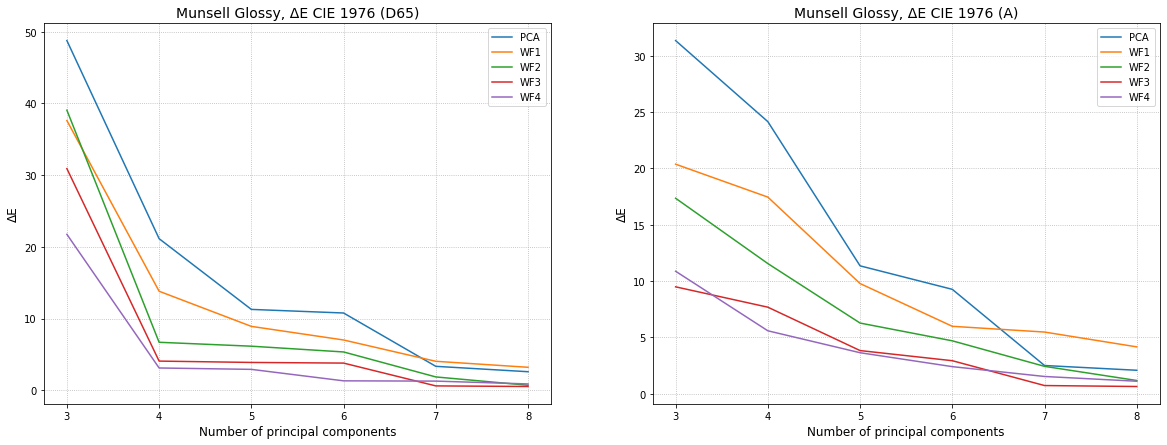

In [72]:
plot_color_errors(munsell_delta_E, error_type='1976', title=('Munsell Glossy, ΔE CIE 1976 (D65)',
                                          'Munsell Glossy, ΔE CIE 1976 (A)'))

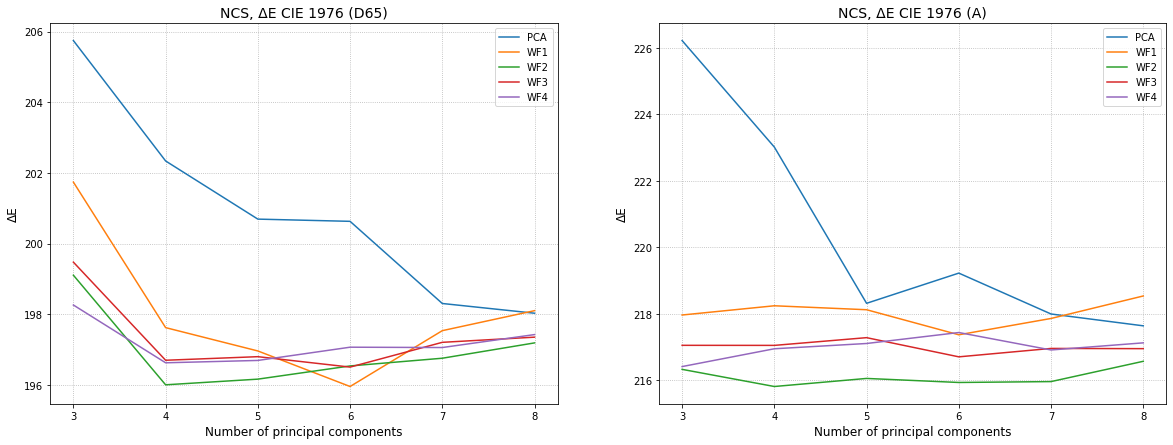

In [73]:
plot_color_errors(NCS_delta_E, error_type='1976',
                  title=('NCS, ΔE CIE 1976 (D65)',
                         'NCS, ΔE CIE 1976 (A)'))

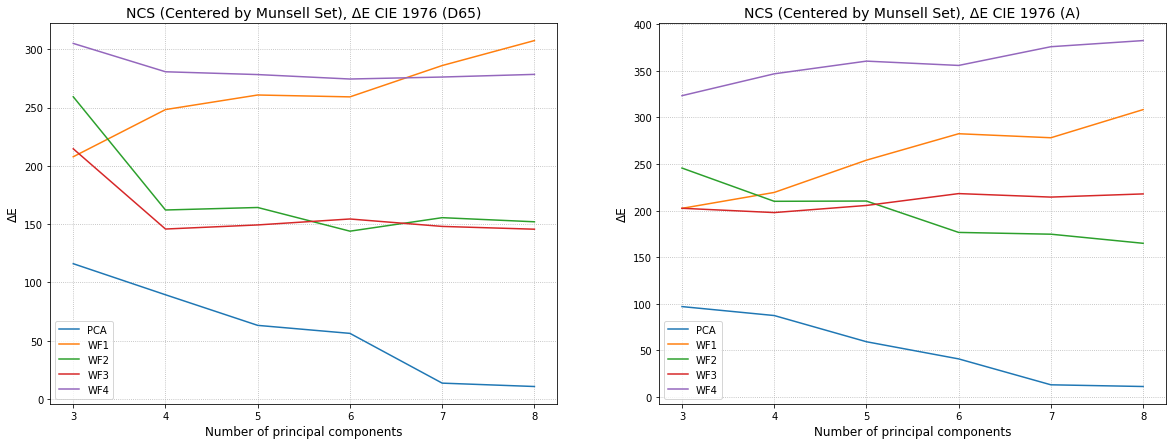

In [74]:
plot_color_errors(NCS_precalc_delta_E, error_type='1976',
                  title=('NCS (Centered by Munsell Set), ΔE CIE 1976 (D65)',
                         'NCS (Centered by Munsell Set), ΔE CIE 1976 (A)'))

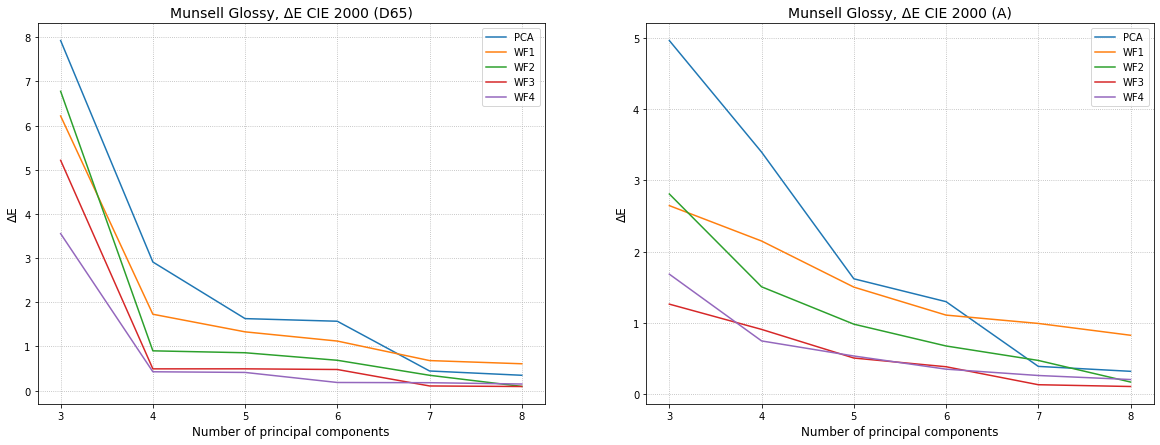

In [75]:
plot_color_errors(munsell_delta_E_2000, error_type='2000',
                  title=('Munsell Glossy, ΔE CIE 2000 (D65)',
                         'Munsell Glossy, ΔE CIE 2000 (A)'))

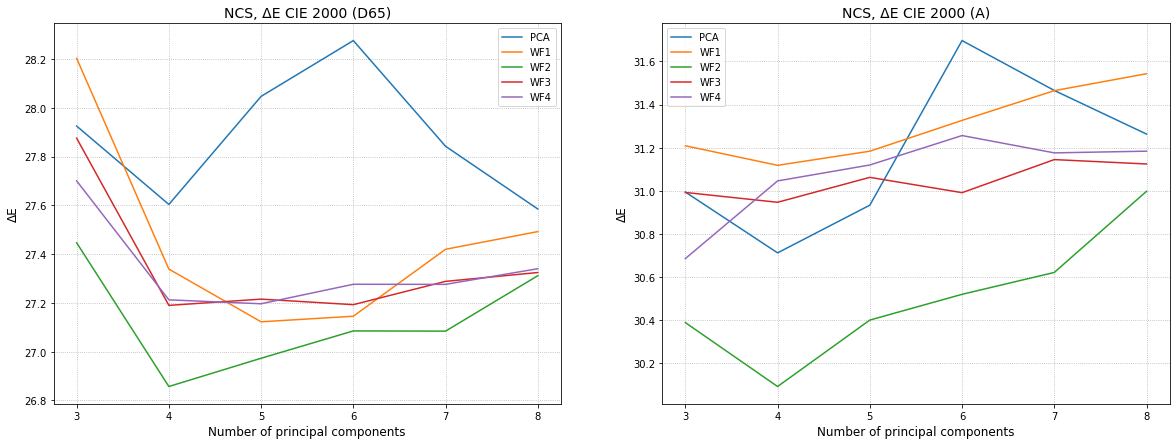

In [76]:
plot_color_errors(NCS_delta_E_2000, error_type='2000',
                  title=('NCS, ΔE CIE 2000 (D65)',
                         'NCS, ΔE CIE 2000 (A)'))

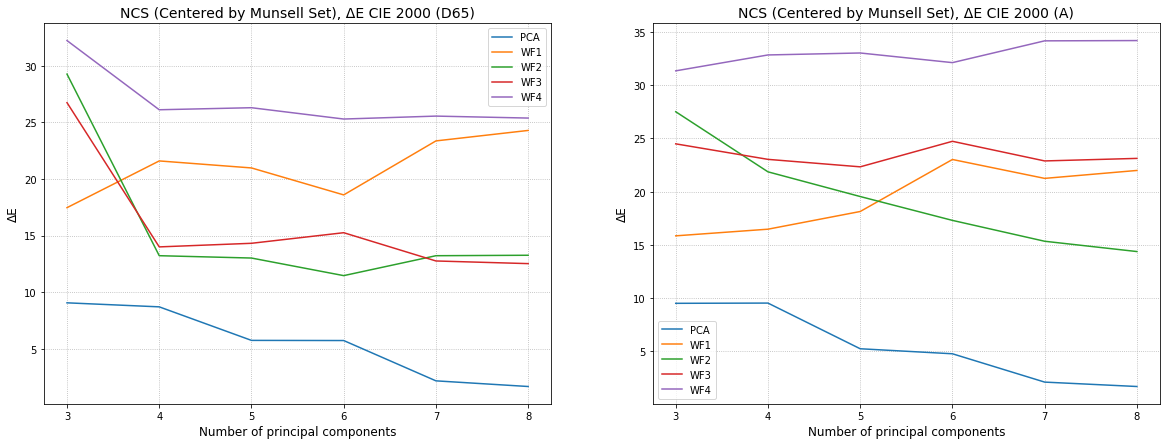

In [77]:
plot_color_errors(NCS_precalc_delta_E_2000, error_type='2000',
                  title=('NCS (Centered by Munsell Set), ΔE CIE 2000 (D65)',
                         'NCS (Centered by Munsell Set), ΔE CIE 2000 (A)'))

### Попытка улучшить результаты восстановления тестовых спектров путём увеличения объёма данных

In [78]:
approximations_NCS_forest = set_approximations('forest', precalc=False)
approximations_NCS_forest_precalc = set_approximations('forest', precalc=True)

# (num_components, pca_version, num_spectra, discretization)
approximations_NCS_forest.shape, approximations_NCS_forest_precalc.shape

((6, 5, 1239, 61), (6, 5, 1239, 61))

#### Спектральная реконструкция

In [79]:
errors_NCS_forest = get_spectra_errors(approximations_NCS_forest, NCS_forest_reflect)
errors_NCS_forest_precalc = get_spectra_errors(approximations_NCS_forest_precalc, NCS_forest_reflect)

In [80]:
forest_errors = np.concatenate((errors_NCS_forest, errors_NCS_forest_precalc), axis=1)
forest_errors = pd.DataFrame(forest_errors, index=np.arange(3, 9),
                      columns=[('RMSE NCS & forest', 'PCA'),('RMSE NCS & forest', 'WF1'),
                               ('RMSE NCS & forest', 'WF2'),('RMSE NCS & forest', 'WF3'),
                               ('RMSE NCS & forest', 'WF4'),
                               ('RMSE NCS & forest (Centered by Munsell Set)', 'PCA'),
                               ('RMSE NCS & forest (Centered by Munsell Set)', 'WF1'),
                               ('RMSE NCS & forest (Centered by Munsell Set)', 'WF2'),
                               ('RMSE NCS & forest (Centered by Munsell Set)', 'WF3'),
                               ('RMSE NCS & forest (Centered by Munsell Set)', 'WF4')])
forest_errors.columns = pd.MultiIndex.from_tuples(forest_errors.columns)

In [81]:
forest_errors

RMSE NCS & forest                                          \
                PCA       WF1       WF2       WF3       WF4   
3          0.226635  0.227032  0.226769  0.226894  0.226947   
4          0.226510  0.226908  0.226626  0.226763  0.226809   
5          0.226362  0.226733  0.226452  0.226586  0.226628   
6          0.226288  0.226622  0.226342  0.226455  0.226577   
7          0.226168  0.226585  0.226271  0.226408  0.226445   
8          0.226143  0.226512  0.226227  0.226321  0.226369   

  RMSE NCS & forest (Centered by Munsell Set)                                \
                                          PCA       WF1       WF2       WF3   
3                                    0.015655  0.047969  0.045194  0.038639   
4                                    0.014724  0.076775  0.057519  0.047771   
5                                    0.013330  0.081309  0.063829  0.055928   
6                                    0.012689  0.102664  0.077783  0.075928   
7                                    0.011129  0.121930  0.079519  0.080948   
8                                    0.010439  0.129726  0.082840  0.094644   

             
        WF4  
3  0.064721  
4  0.075896  
5  0.088209  
6  0.088052  
7  0.124061  
8  0.129558

In [82]:
all_errors

RMSE Munsell                                          RMSE NCS            \
           PCA       WF1       WF2       WF3       WF4       PCA       WF1   
3     0.021134  0.026510  0.022945  0.024092  0.024941  0.072012  0.076329   
4     0.014436  0.018955  0.015725  0.016939  0.017557  0.070087  0.074778   
5     0.010574  0.015060  0.011600  0.013047  0.013577  0.068179  0.073226   
6     0.008268  0.012668  0.008966  0.010542  0.012275  0.066694  0.071490   
7     0.006289  0.011220  0.007254  0.009135  0.009606  0.064806  0.070522   
8     0.005022  0.009916  0.005636  0.007457  0.008237  0.064276  0.069756   

                                RMSE NCS (Centered by Munsell Set)            \
        WF2       WF3       WF4                                PCA       WF1   
3  0.073412  0.074761  0.075345                           0.044189  0.160540   
4  0.071383  0.072991  0.073501                           0.040879  0.274643   
5  0.069448  0.071198  0.071776                           0.035293  0.292494   
6  0.067543  0.069102  0.070904                           0.032282  0.387356   
7  0.066287  0.068140  0.068655                           0.028277  0.457889   
8  0.065419  0.066747  0.067534                           0.026987  0.498150   

                                 
        WF2       WF3       WF4  
3  0.160390  0.133022  0.230292  
4  0.213251  0.177350  0.286793  
5  0.237270  0.207942  0.333485  
6  0.296181  0.294286  0.332416  
7  0.302610  0.313427  0.482414  
8  0.314276  0.375568  0.510367

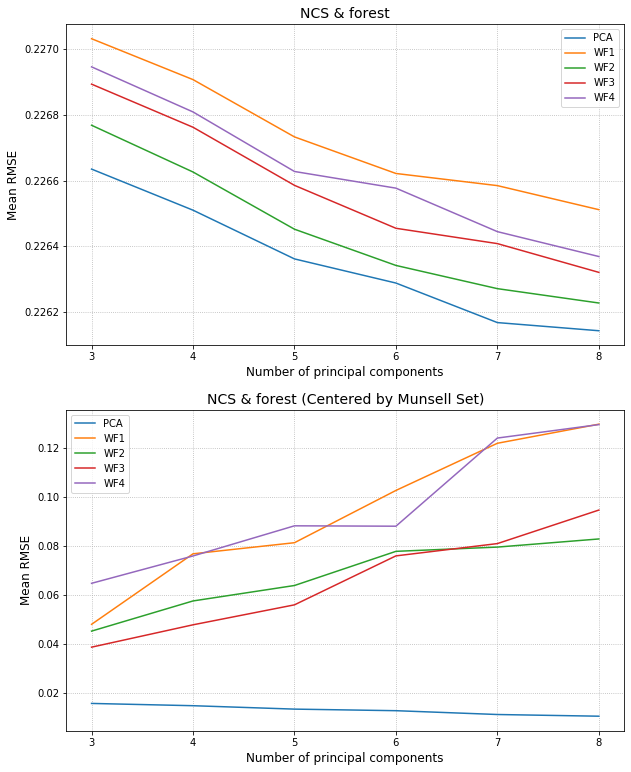

In [83]:
fig, axs = plt.subplots(2, 1, figsize=(10, 13))

approx_versions = ['RMSE NCS & forest', 'RMSE NCS & forest (Centered by Munsell Set)']
titles = ['NCS & forest', 'NCS & forest (Centered by Munsell Set)']

for i, ax in zip(range(2), axs.reshape(-1)):
    ax.plot(forest_errors.index, forest_errors[approx_versions[i]]['PCA'].values, label='PCA')
    ax.plot(forest_errors.index, forest_errors[approx_versions[i]]['WF1'].values, label='WF1')
    ax.plot(forest_errors.index, forest_errors[approx_versions[i]]['WF2'].values, label='WF2')
    ax.plot(forest_errors.index, forest_errors[approx_versions[i]]['WF3'].values, label='WF3')
    ax.plot(forest_errors.index, forest_errors[approx_versions[i]]['WF4'].values, label='WF4')
    
    ax.set_title(titles[i], fontsize=14)
    ax.grid(ls=':')
    ax.set_ylabel('Mean RMSE', fontsize=12)
    ax.set_xlabel('Number of principal components', fontsize=12)
    ax.legend()

plt.show()

#### Колриметрическая реконструкиция

In [84]:
XYZ_NCS_forest_D65 = get_XYZ(NCS_forest_reflect, D_65)
XYZ_NCS_forest_A = get_XYZ(NCS_forest_reflect, A)

In [85]:
XYZ_NCS_forest_D65_approx = get_XYZ_approx(approximations_NCS_forest, D_65)
XYZ_NCS_forest_A_approx = get_XYZ_approx(approximations_NCS_forest, A)

XYZ_NCS_forest_precalc_D_65_approx = get_XYZ_approx(approximations_NCS_forest_precalc, D_65)
XYZ_NCS_forest_precalc_A_approx = get_XYZ_approx(approximations_NCS_forest_precalc, A)

In [86]:
# конвертация XYZ --> Lab
Lab_NCS_forest_D65 = get_Lab(XYZ_NCS_forest_D65, 'd65')
Lab_NCS_forest_A = get_Lab(XYZ_NCS_forest_A, 'a')

In [87]:
Lab_NCS_forest_D_65_approx = get_Lab_approx(XYZ_NCS_forest_D65_approx, 'd65')
Lab_NCS_forest_A_approx = get_Lab_approx(XYZ_NCS_forest_A_approx, 'a')

Lab_NCS_forest_precalc_D_65_approx = get_Lab_approx(XYZ_NCS_forest_precalc_D_65_approx, 'd65')
Lab_NCS_forest_precalc_A_approx = get_Lab_approx(XYZ_NCS_forest_precalc_A_approx, 'a')

In [88]:
NCS_forest_D65_delta_E_1976 = get_delta_E(Lab_NCS_forest_D_65_approx, Lab_NCS_forest_D65, '1976')
NCS_forest_A_delta_E_1976 = get_delta_E(Lab_NCS_forest_A_approx, Lab_NCS_forest_A, '1976')

NCS_forest_precalc_D65_delta_E_1976 = get_delta_E(Lab_NCS_forest_precalc_D_65_approx, Lab_NCS_forest_D65, '1976')
NCS_forest_precalc_A_delta_E_1976 = get_delta_E(Lab_NCS_forest_precalc_A_approx, Lab_NCS_forest_A, '1976')

In [89]:
NCS_forest_D65_delta_E_2000 = get_delta_E(Lab_NCS_forest_D_65_approx, Lab_NCS_forest_D65, '2000')
NCS_forest_A_delta_E_2000 = get_delta_E(Lab_NCS_forest_A_approx, Lab_NCS_forest_A, '2000')

NCS_forest_precalc_D65_delta_E_2000 = get_delta_E(Lab_NCS_forest_precalc_D_65_approx, Lab_NCS_forest_D65, '2000')
NCS_forest_precalc_A_delta_E_2000 = get_delta_E(Lab_NCS_forest_precalc_A_approx, Lab_NCS_forest_A, '2000')

In [90]:
NCS_forest_delta_E = np.concatenate((NCS_forest_D65_delta_E_1976, NCS_forest_A_delta_E_1976), axis=1)
NCS_forest_delta_E = pd.DataFrame(NCS_forest_delta_E, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 76 (D65)', 'PCA'),('Mean ΔE CIE 76 (D65)', 'WF1'),
                               ('Mean ΔE CIE 76 (D65)', 'WF2'),('Mean ΔE CIE 76 (D65)', 'WF3'),
                               ('Mean ΔE CIE 76 (D65)', 'WF4'),('Mean ΔE CIE 76 (A)', 'PCA'),
                               ('Mean ΔE CIE 76 (A)', 'WF1'),('Mean ΔE CIE 76 (A)', 'WF2'),
                               ('Mean ΔE CIE 76 (A)', 'WF3'),('Mean ΔE CIE 76 (A)', 'WF4')])
NCS_forest_delta_E.columns = pd.MultiIndex.from_tuples(NCS_forest_delta_E.columns)

In [91]:
NCS_forest_precalc_delta_E = np.concatenate((NCS_forest_precalc_D65_delta_E_1976, NCS_forest_precalc_A_delta_E_1976), axis=1)
NCS_forest_precalc_delta_E = pd.DataFrame(NCS_forest_precalc_delta_E, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 76 (D65)', 'PCA'),('Mean ΔE CIE 76 (D65)', 'WF1'),
                               ('Mean ΔE CIE 76 (D65)', 'WF2'),('Mean ΔE CIE 76 (D65)', 'WF3'),
                               ('Mean ΔE CIE 76 (D65)', 'WF4'),('Mean ΔE CIE 76 (A)', 'PCA'),
                               ('Mean ΔE CIE 76 (A)', 'WF1'),('Mean ΔE CIE 76 (A)', 'WF2'),
                               ('Mean ΔE CIE 76 (A)', 'WF3'),('Mean ΔE CIE 76 (A)', 'WF4')])
NCS_forest_precalc_delta_E.columns = pd.MultiIndex.from_tuples(NCS_forest_precalc_delta_E.columns)

In [92]:
NCS_forest_delta_E_2000 = np.concatenate((NCS_forest_precalc_D65_delta_E_2000, NCS_forest_precalc_A_delta_E_2000), axis=1)
NCS_forest_delta_E_2000 = pd.DataFrame(NCS_forest_delta_E_2000, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 2000 (D65)', 'PCA'),('Mean ΔE CIE 2000 (D65)', 'WF1'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF2'),('Mean ΔE CIE 2000 (D65)', 'WF3'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF4'),('Mean ΔE CIE 2000 (A)', 'PCA'),
                               ('Mean ΔE CIE 2000 (A)', 'WF1'),('Mean ΔE CIE 2000 (A)', 'WF2'),
                               ('Mean ΔE CIE 2000 (A)', 'WF3'),('Mean ΔE CIE 2000 (A)', 'WF4')])
NCS_forest_delta_E_2000.columns = pd.MultiIndex.from_tuples(NCS_forest_delta_E_2000.columns)

In [93]:
NCS_forest_precalc_delta_E_2000 = np.concatenate((NCS_forest_precalc_D65_delta_E_2000, NCS_forest_precalc_A_delta_E_2000), axis=1)
NCS_forest_precalc_delta_E_2000 = pd.DataFrame(NCS_forest_precalc_delta_E_2000, index=np.arange(3, 9),
                      columns=[('Mean ΔE CIE 2000 (D65)', 'PCA'),('Mean ΔE CIE 2000 (D65)', 'WF1'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF2'),('Mean ΔE CIE 2000 (D65)', 'WF3'),
                               ('Mean ΔE CIE 2000 (D65)', 'WF4'),('Mean ΔE CIE 2000 (A)', 'PCA'),
                               ('Mean ΔE CIE 2000 (A)', 'WF1'),('Mean ΔE CIE 2000 (A)', 'WF2'),
                               ('Mean ΔE CIE 2000 (A)', 'WF3'),('Mean ΔE CIE 2000 (A)', 'WF4')])
NCS_forest_precalc_delta_E_2000.columns = pd.MultiIndex.from_tuples(NCS_forest_precalc_delta_E_2000.columns)

In [94]:
NCS_forest_delta_E

Mean ΔE CIE 76 (D65)                                                  \
                   PCA         WF1         WF2         WF3         WF4   
3           439.472620  440.937125  439.864968  440.398915  440.622127   
4           440.541353  441.063274  440.579190  440.812179  440.874985   
5           440.957389  440.952187  440.647997  440.803145  440.862796   
6           440.899298  440.745384  440.714870  440.750095  440.879070   
7           440.932807  440.977960  440.832689  440.882941  440.879163   
8           440.973628  441.019207  440.869730  440.905549  440.931672   

  Mean ΔE CIE 76 (A)                                                  
                 PCA         WF1         WF2         WF3         WF4  
3         441.965083  443.300131  442.220153  442.771151  443.094212  
4         442.466908  443.157324  442.477008  442.763144  442.853192  
5         442.848142  443.083960  442.628024  442.771060  442.829548  
6         442.793625  442.812780  442.584908  442.650567  442.828422  
7         442.662455  442.904429  442.643569  442.725382  442.746643  
8         442.691047  442.884603  442.667519  442.722417  442.759470

In [95]:
NCS_delta_E

Mean ΔE CIE 76 (D65)                                                  \
                   PCA         WF1         WF2         WF3         WF4   
3           205.743696  201.739025  199.104657  199.474175  198.261287   
4           202.337215  197.621455  196.003388  196.698163  196.626465   
5           200.691628  196.961088  196.163667  196.799388  196.692906   
6           200.628923  195.955384  196.536968  196.504449  197.067539   
7           198.304238  197.535586  196.755398  197.205274  197.058144   
8           198.029164  198.101379  197.189369  197.351627  197.424671   

  Mean ΔE CIE 76 (A)                                                  
                 PCA         WF1         WF2         WF3         WF4  
3         226.210838  217.958818  216.324507  217.047316  216.408407  
4         223.008540  218.236471  215.809042  217.045342  216.943785  
5         218.310663  218.117596  216.051628  217.277949  217.102333  
6         219.218677  217.364060  215.930236  216.700933  217.432058  
7         217.989427  217.855084  215.956707  216.953657  216.907542  
8         217.633631  218.531336  216.566987  216.947151  217.121611

In [96]:
NCS_forest_precalc_delta_E

Mean ΔE CIE 76 (D65)                                                 \
                   PCA         WF1         WF2        WF3         WF4   
3            79.506621  116.069142  101.329206  84.008044  153.701512   
4            52.160205  162.332974   88.740794  71.371732  149.998243   
5            52.154295  160.641699   92.593296  73.770144  149.100784   
6            49.854160  151.448876   87.352485  74.375462  147.382728   
7            12.205430  173.478018   94.544384  75.455669  148.505183   
8             8.228669  179.242831   95.560886  75.144324  149.489119   

  Mean ΔE CIE 76 (A)                                                  
                 PCA         WF1         WF2         WF3         WF4  
3          48.228564  106.631259  114.751486   99.521199  182.342737  
4          47.020875  121.437977  103.991455   98.858578  188.750352  
5          42.797689  135.750154  104.689125  103.204655  195.946843  
6          37.001875  145.859181   89.924338  109.240779  193.929990  
7          12.286268  146.680700   90.514141  108.063867  203.772816  
8          10.610328  154.901011   85.518539  109.644125  205.963024

In [97]:
NCS_precalc_delta_E

Mean ΔE CIE 76 (D65)                                                  \
                   PCA         WF1         WF2         WF3         WF4   
3           115.994692  207.767380  259.235376  214.588592  305.010256   
4            89.334382  248.246489  162.077248  145.739838  280.692646   
5            63.069168  260.755636  164.221803  149.257204  278.287048   
6            56.204556  259.147259  143.902756  154.362364  274.468452   
7            13.500177  286.031437  155.489691  147.987252  276.174135   
8            10.612311  307.455674  151.958885  145.593746  278.448161   

  Mean ΔE CIE 76 (A)                                                  
                 PCA         WF1         WF2         WF3         WF4  
3          97.053565  202.431612  245.640463  202.503454  323.276076  
4          87.450769  219.484204  209.978240  197.894399  346.717538  
5          59.346072  254.109027  210.255517  205.538013  360.334021  
6          40.940234  282.460190  176.602585  218.248316  355.713706  
7          13.158314  278.152530  174.701404  214.498044  375.800533  
8          11.333710  308.341824  164.937715  217.905555  382.376646

In [98]:
NCS_forest_delta_E_2000

Mean ΔE CIE 2000 (D65)                                              \
                     PCA        WF1        WF2        WF3        WF4   
3               7.687776  12.777319  16.577661  14.701460  27.251338   
4               5.786769  17.449147   9.705297  10.023602  24.658339   
5               5.067541  16.298293   9.772811  10.460875  24.780936   
6               5.140417  14.995303   9.201905  11.058010  23.911719   
7               2.625279  17.626625  10.088148   9.721450  24.155986   
8               1.940230  17.782917  10.430611   9.516520  24.021796   

  Mean ΔE CIE 2000 (A)                                              
                   PCA        WF1        WF2        WF3        WF4  
3             5.902154  12.473963  23.870205  22.707882  35.587843  
4             7.519545  13.344785  19.641188  22.120901  36.312583  
5             4.257967  15.495507  16.439783  21.466030  36.383049  
6             4.210805  20.640345  14.024504  24.220320  35.551085  
7             3.225236  18.665446  13.084882  22.460151  38.285274  
8             2.549139  19.425023  11.416195  22.779133  38.362851

In [99]:
NCS_delta_E_2000

Mean ΔE CIE 2000 (D65)                                              \
                     PCA        WF1        WF2        WF3        WF4   
3              27.924891  28.202428  27.446391  27.875106  27.700026   
4              27.603466  27.338412  26.857130  27.189690  27.212340   
5              28.046494  27.122355  26.972928  27.215333  27.196286   
6              28.275266  27.145280  27.085013  27.192632  27.276211   
7              27.841940  27.419717  27.084161  27.288121  27.275860   
8              27.584824  27.492190  27.311347  27.324396  27.339970   

  Mean ΔE CIE 2000 (A)                                              
                   PCA        WF1        WF2        WF3        WF4  
3            30.993940  31.208850  30.388122  30.992131  30.685319  
4            30.711803  31.118030  30.091612  30.946557  31.045688  
5            30.933081  31.183526  30.399951  31.062225  31.119606  
6            31.696988  31.326483  30.519399  30.991145  31.256247  
7            31.465473  31.464560  30.620989  31.144631  31.175846  
8            31.263087  31.543101  30.997534  31.124301  31.183728

In [100]:
NCS_forest_precalc_delta_E_2000

Mean ΔE CIE 2000 (D65)                                              \
                     PCA        WF1        WF2        WF3        WF4   
3               7.687776  12.777319  16.577661  14.701460  27.251338   
4               5.786769  17.449147   9.705297  10.023602  24.658339   
5               5.067541  16.298293   9.772811  10.460875  24.780936   
6               5.140417  14.995303   9.201905  11.058010  23.911719   
7               2.625279  17.626625  10.088148   9.721450  24.155986   
8               1.940230  17.782917  10.430611   9.516520  24.021796   

  Mean ΔE CIE 2000 (A)                                              
                   PCA        WF1        WF2        WF3        WF4  
3             5.902154  12.473963  23.870205  22.707882  35.587843  
4             7.519545  13.344785  19.641188  22.120901  36.312583  
5             4.257967  15.495507  16.439783  21.466030  36.383049  
6             4.210805  20.640345  14.024504  24.220320  35.551085  
7             3.225236  18.665446  13.084882  22.460151  38.285274  
8             2.549139  19.425023  11.416195  22.779133  38.362851

In [101]:
NCS_precalc_delta_E_2000

Mean ΔE CIE 2000 (D65)                                              \
                     PCA        WF1        WF2        WF3        WF4   
3               9.063578  17.463604  29.251831  26.731469  32.212348   
4               8.708562  21.588995  13.223255  14.000492  26.106014   
5               5.748382  20.970423  13.016822  14.318557  26.286279   
6               5.734914  18.589660  11.464475  15.253097  25.286897   
7               2.176629  23.356098  13.222272  12.758238  25.546187   
8               1.677332  24.280456  13.262340  12.524340  25.372259   

  Mean ΔE CIE 2000 (A)                                              
                   PCA        WF1        WF2        WF3        WF4  
3             9.512466  15.850357  27.506772  24.491189  31.348114  
4             9.534631  16.475202  21.862345  23.034062  32.840727  
5             5.244597  18.136707  19.542958  22.332234  33.025640  
6             4.773428  23.021806  17.302270  24.729998  32.119576  
7             2.112674  21.246901  15.342296  22.886126  34.165870  
8             1.699141  21.991334  14.374947  23.124608  34.191014

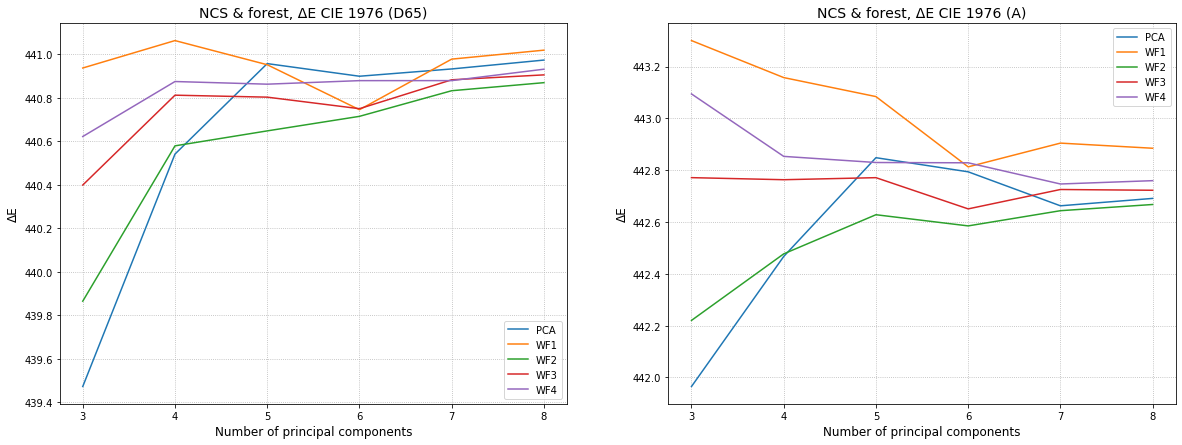

In [102]:
plot_color_errors(NCS_forest_delta_E, error_type='1976', title=('NCS & forest, ΔE CIE 1976 (D65)',
                                          'NCS & forest, ΔE CIE 1976 (A)'))

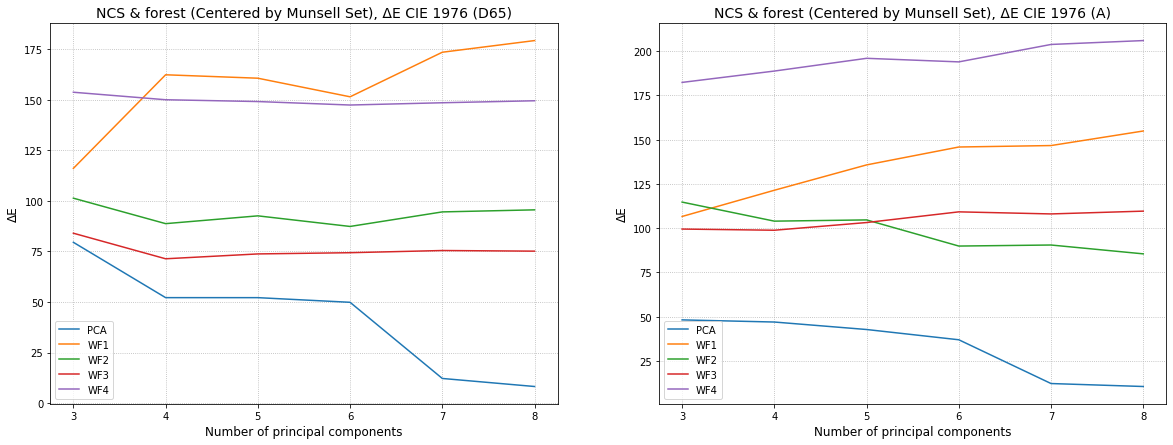

In [103]:
plot_color_errors(NCS_forest_precalc_delta_E, error_type='1976', title=('NCS & forest (Centered by Munsell Set), ΔE CIE 1976 (D65)',
                                          'NCS & forest (Centered by Munsell Set), ΔE CIE 1976 (A)'))

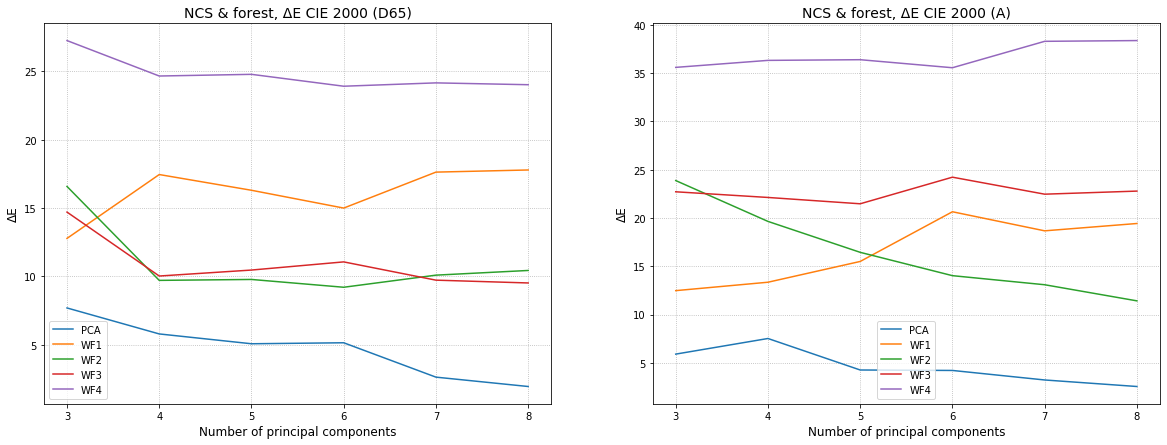

In [104]:
plot_color_errors(NCS_forest_delta_E_2000, error_type='2000', title=('NCS & forest, ΔE CIE 2000 (D65)',
                                          'NCS & forest, ΔE CIE 2000 (A)'))

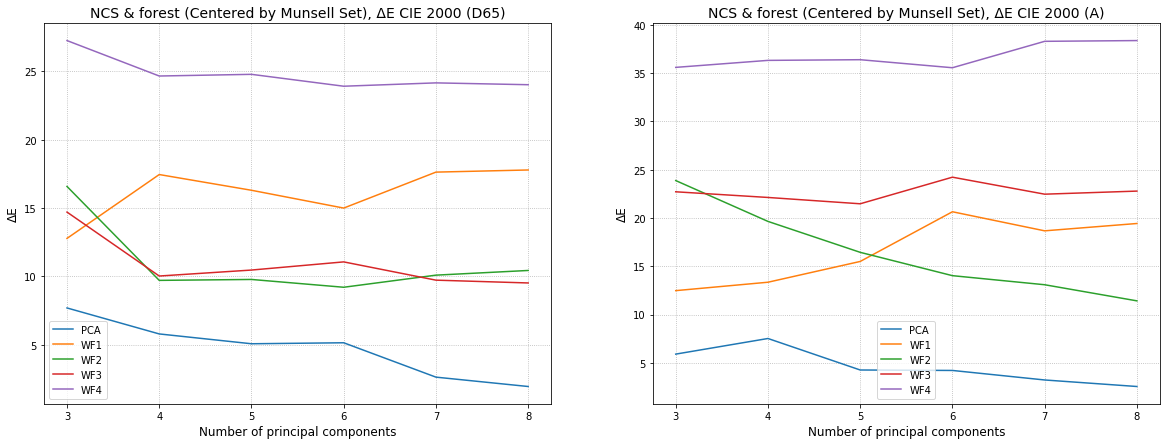

In [105]:
plot_color_errors(NCS_forest_precalc_delta_E_2000, error_type='2000', title=('NCS & forest (Centered by Munsell Set), ΔE CIE 2000 (D65)',
                                          'NCS & forest (Centered by Munsell Set), ΔE CIE 2000 (A)'))